#  #개인 대출 부도 및 연체에 대한 예측 모델링
  - 소속 : 광주은행
  - 팀명 : 김다혜
  - 팀원 : 김다혜

>>> # 목차 <br>

>> 0. 분석 배경 및 계획 수립 <br>
>> 1. Setting <br>
>> 2. EDA <br>
>> 3. Feature Engineering <br>
>> 4. Modeling <br>
>> 5. Prediction <br>
>> 6. 최종결과 <br>
>> 7. 기대효과 <br>
>> <span style="color:red;"> 8. **★Scoring★** </span>

# 0. 분석 배경 및 계획 수립
* 분석 배경 : 금융산업에서 가장 보수적인 영역인 신용평가 업무가 인공지능(AI)과 빅데이터 영역으로 편입됨에 따라, 신뢰성 높은 신용평가모형의 중요성이 점차 증가하고 있음.
* 분석 목표 : 고객의 대출/신용평가 정보를 활용하여 채무 불이행 가능성이 높은 고객의 유입을 사전에 방지하고, 건전성 강화에 기여
* 분석 방향 : 제공된 데이터셋을 Train / Valid / Test 세개의 Dataset으로 나누어 학습 및 평가를 통해 예측 하고자함.

# 1. Setting

> ## 1-1. Import Module

In [3]:
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier

from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

> ## 1-2. Read Data

In [4]:
df = pd.read_csv('../0.data/loan_customer.csv')

In [5]:
# data shape check
print('loan_data shape: ', df.shape)
df.head()

loan_data shape:  (24000, 35)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,CB_SCORE_1,CB_SCORE_2,CB_SCORE_3,TARGET
0,100002,Cash loans,M,Y,0,202500.0,NaN,Working,Secondary / secondary special,Single / not married,...,0,0,Business Entity Type 3,0,1,0,NaN,NaN,58.349224,1
1,100004,Revolving loans,NaN,NaN,0,67500.0,135000.0,Working,Secondary / secondary special,Single / not married,...,0,0,Government,0,0,0,26.499494,57.600542,46.433666,0
2,100020,Cash loans,M,N,0,108000.0,509602.5,Working,Secondary / secondary special,Married,...,1,0,Government,0,1,0,NaN,63.496369,NaN,0
3,100029,Cash loans,M,N,2,135000.0,NaN,Working,Secondary / secondary special,Married,...,1,1,Business Entity Type 3,0,1,0,82.376245,45.996152,68.694333,0
4,100048,Cash loans,NaN,Y,0,202500.0,604152.0,Working,Secondary / secondary special,Married,...,1,1,Industry: type 1,0,1,0,66.199985,NaN,NaN,0


In [6]:
# unique key
df.loc[df.duplicated("SK_ID_CURR")]

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,CB_SCORE_1,CB_SCORE_2,CB_SCORE_3,TARGET


# 2. Exploratory Data Analysis

> ## 2-1. Target Col 확인

In [7]:
Target_df = df.groupby("TARGET").SK_ID_CURR.agg(['count']).reset_index()
Target_df.columns = ['TARGET', 'Tcnt']
Target_df['Rt'] = Target_df['Tcnt'] / df.shape[0]

In [8]:
Target_df

,TARGET,Tcnt,Rt
0,0,22007,0.916958
1,1,1993,0.083042


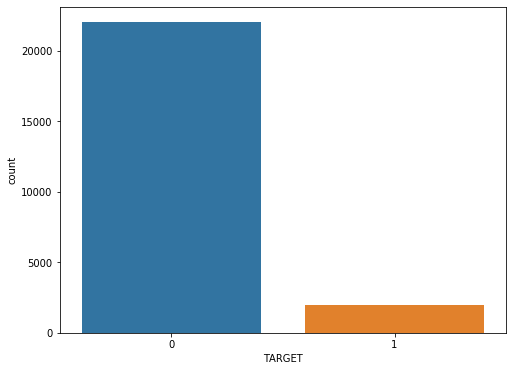

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.countplot(x='TARGET', data=df)
plt.show()

----

> ## 2-2. Cols Null 확인

In [10]:
# null값이 있는 cols null 점유비
null_df = df.isnull().sum().reset_index()
null_df.columns = ['ColName', 'Ncnt']
null_df['Rt'] = null_df['Ncnt'] / df.shape[0]
null_df.loc[null_df.Ncnt > 0].sort_values(["Ncnt"],ascending=False).reset_index(drop=True)

,ColName,Ncnt,Rt
0,DAYS_REGISTRATION,9733,0.405542
1,FLAG_OWN_REALTY,9571,0.398792
2,CB_SCORE_2,8274,0.344750
3,AMT_CREDIT,7300,0.304167
4,REGION_POPULATION_RELATIVE,7149,0.297875
5,DAYS_EMPLOYED,7149,0.297875
6,CB_SCORE_3,7108,0.296167
7,CODE_GENDER,7094,0.295583
8,CB_SCORE_1,6146,0.256083
9,DAYS_BIRTH,4749,0.197875


> <span style="color:darkblue;background-color:#fff5b1"> **결측치 Cols** </span>  <br>
> -> **범주형(2) : FLAG_OWN_REALTY, CODE_GENDER** <br>
> -> **연속형(9) : DAYS_REGISTRATION, AMT_CREDIT, REGION_POPULATION_RELATIVE, DAYS_EMPLOYED, DAYS_BIRTH, DAYS_ID_PUBLISH, CB_SCORE_1, CB_SCORE_2, CB_SCORE_3** <br>

----

> ## 2-3. Cols Type 확인 및 분류 (obj, i64, f64)
>   - unique key: SK_ID_CURR, Y: TARGET 분류에서 제외
>   - int64(14), float64(10), object(9)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SK_ID_CURR                  24000 non-null  int64  
 1   NAME_CONTRACT_TYPE          24000 non-null  object 
 2   CODE_GENDER                 16906 non-null  object 
 3   FLAG_OWN_REALTY             14429 non-null  object 
 4   CNT_CHILDREN                24000 non-null  int64  
 5   AMT_INCOME_TOTAL            24000 non-null  float64
 6   AMT_CREDIT                  16700 non-null  float64
 7   NAME_INCOME_TYPE            24000 non-null  object 
 8   NAME_EDUCATION_TYPE         24000 non-null  object 
 9   NAME_FAMILY_STATUS          24000 non-null  object 
 10  NAME_HOUSING_TYPE           24000 non-null  object 
 11  REGION_POPULATION_RELATIVE  16851 non-null  float64
 12  DAYS_BIRTH                  19251 non-null  float64
 13  DAYS_EMPLOYED               168

In [12]:
obj = [col for col in df.columns if (df[col].dtypes == "object") &(col != "SK_ID_CURR")&(col != "TARGET")]
i64 = [col for col in df.columns if (df[col].dtypes == "int64")  &(col != "SK_ID_CURR")&(col != "TARGET")]
f64 = [col for col in df.columns if (df[col].dtypes == "float64")&(col != "SK_ID_CURR")&(col != "TARGET")]

In [13]:
print("float64:",len(f64),", int64:",len(i64),", object:",len(obj))

float64: 10 , int64: 14 , object: 9


> <span style="color:darkblue;background-color:#fff5b1"> **Cols Type** </span>  <br>
> -> **f64(10) : AMT_INCOME_TOTAL, AMT_CREDIT, REGION_POPULATION_RELATIVE, DAYS_BIRTH, CB_SCORE_1 ...** <br>
> -> **i64(14) : CNT_CHILDREN, FLAG_MOBIL, REGION_RATING_CLIENT, HOUR_APPR_PROCESS_START, FLAG_DOCUMENT_2 ...** <br>
> -> **obj(9)  : NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_REALTY, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE ...** <br>

----

> ## 2-4. Cols 속성
>   - Cols 재분류

In [14]:
# obj(범주)형 데이터 (범주갯수)
for col in df.columns:
    if df[col].dtype == 'object':
        categories = df[col].unique()
        print(f'[ColName : {col}], (Count : {len(categories)}개)')

[ColName : NAME_CONTRACT_TYPE], (Count : 2개)
[ColName : CODE_GENDER], (Count : 4개)
[ColName : FLAG_OWN_REALTY], (Count : 3개)
[ColName : NAME_INCOME_TYPE], (Count : 7개)
[ColName : NAME_EDUCATION_TYPE], (Count : 5개)
[ColName : NAME_FAMILY_STATUS], (Count : 6개)
[ColName : NAME_HOUSING_TYPE], (Count : 6개)
[ColName : WEEKDAY_APPR_PROCESS_START], (Count : 7개)
[ColName : ORGANIZATION_TYPE], (Count : 58개)


In [15]:
# int64형 데이터 (범주갯수)
for col in i64:
    categories = df[col].unique()
    print(f'[ColName : {col}], (Count : {len(categories)}개)')

[ColName : CNT_CHILDREN], (Count : 7개)
[ColName : FLAG_MOBIL], (Count : 1개)
[ColName : FLAG_EMP_PHONE], (Count : 2개)
[ColName : FLAG_WORK_PHONE], (Count : 2개)
[ColName : FLAG_PHONE], (Count : 2개)
[ColName : FLAG_EMAIL], (Count : 2개)
[ColName : REGION_RATING_CLIENT], (Count : 3개)
[ColName : HOUR_APPR_PROCESS_START], (Count : 24개)
[ColName : REG_CITY_NOT_LIVE_CITY], (Count : 2개)
[ColName : REG_CITY_NOT_WORK_CITY], (Count : 2개)
[ColName : LIVE_CITY_NOT_WORK_CITY], (Count : 2개)
[ColName : FLAG_DOCUMENT_2], (Count : 2개)
[ColName : FLAG_DOCUMENT_3], (Count : 2개)
[ColName : FLAG_DOCUMENT_4], (Count : 2개)


In [16]:
# float64형 데이터 (범주갯수)
for col in f64:
    categories = df[col].unique()
    print(f'[ColName : {col}], (Count : {len(categories)}개)')

[ColName : AMT_INCOME_TOTAL], (Count : 494개)
[ColName : AMT_CREDIT], (Count : 2267개)
[ColName : REGION_POPULATION_RELATIVE], (Count : 82개)
[ColName : DAYS_BIRTH], (Count : 11222개)
[ColName : DAYS_EMPLOYED], (Count : 5431개)
[ColName : DAYS_REGISTRATION], (Count : 8207개)
[ColName : DAYS_ID_PUBLISH], (Count : 5247개)
[ColName : CB_SCORE_1], (Count : 17855개)
[ColName : CB_SCORE_2], (Count : 15727개)
[ColName : CB_SCORE_3], (Count : 16892개)


In [17]:
# i64 cols string 변환
for col in i64:
    df[col] = df[col].astype(str)

In [18]:
# SK_ID_CURR string 변환
df.SK_ID_CURR = df.SK_ID_CURR.astype(str)

In [19]:
# CNT_CHILDREN to float64
df.CNT_CHILDREN = df.CNT_CHILDREN.astype('float64')

In [20]:
# FLAG_OWN_REALTY (Y,N ==> 1,0) 변환
df.FLAG_OWN_REALTY = [1 if realty == "Y" else 0 if realty == "N" else 0 for realty in df.FLAG_OWN_REALTY]    

In [21]:
# bool cols to int64
bol = [col for col in df.columns if "FLAG_" in col] + [col for col in df.columns if "REG_" in col] + ["LIVE_CITY_NOT_WORK_CITY","REGION_RATING_CLIENT"]
for colB in bol:
    df[colB] = df[colB].astype('int64')

In [22]:
bol = [col for col in df.columns if "FLAG_" in col] + [col for col in df.columns if "REG_" in col] + ["LIVE_CITY_NOT_WORK_CITY","REGION_RATING_CLIENT"]
obj = [col for col in df.columns if (df[col].dtypes == "object") &(col != "SK_ID_CURR")&(col != "TARGET")]
f64 = [col for col in df.columns if (df[col].dtypes == "float64")&(col != "SK_ID_CURR")&(col != "TARGET")]
i64 = ["SK_ID_CURR","TARGET"]

In [23]:
print("bool:",len(bol),",", "object:",len(obj),",", "float64:",len(f64),",", "int64:",len(i64))

bool: 13 , object: 9 , float64: 11 , int64: 2


In [24]:
df.describe()

,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,CB_SCORE_1,CB_SCORE_2,CB_SCORE_3,TARGET
count,24000.000000,24000.000000,2.400000e+04,1.670000e+04,16851.000000,19251.000000,16851.000000,14267.000000,19259.000000,24000.0,...,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,17854.000000,15726.000000,16892.000000,24000.000000
mean,0.414125,0.418083,1.725182e+05,5.954254e+05,0.020989,-16026.527453,63041.865112,-5016.930118,-2990.491926,1.0,...,0.076583,0.232042,0.181750,0.000167,0.709292,0.000125,49.942357,58.061950,60.368432,0.083042
std,0.492581,0.727194,7.604604e+05,3.988125e+05,0.014061,4365.267387,140634.051334,3541.618561,1513.089981,0.0,...,0.265935,0.422144,0.385646,0.012909,0.454099,0.011180,13.095990,10.752802,8.682502,0.275951
min,0.000000,0.000000,2.700000e+04,4.500000e+04,0.000290,-25197.000000,-16852.000000,-24672.000000,-6263.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.967147,0.000000
25%,0.000000,0.000000,1.125000e+05,2.700000e+05,0.010006,-19647.000000,-2772.000000,-7537.000000,-4308.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.026337,50.801249,54.410659,0.000000
50%,0.000000,0.000000,1.440000e+05,5.108535e+05,0.018850,-15731.000000,-1206.000000,-4521.000000,-3251.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.894802,57.935604,59.971539,0.000000
75%,1.000000,1.000000,2.025000e+05,8.086500e+05,0.028663,-12376.500000,-299.000000,-2050.500000,-1717.500000,1.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,58.919900,65.184718,66.097419,0.000000
max,1.000000,7.000000,1.170000e+08,4.050000e+06,0.072508,-7688.000000,365243.000000,0.000000,0.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,99.870790,98.987986,100.000000,1.000000


In [25]:
# 범주형 데이터
df[df.columns.difference(['SK_ID_CURR'])].describe(include='O')

,CODE_GENDER,HOUR_APPR_PROCESS_START,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,ORGANIZATION_TYPE,WEEKDAY_APPR_PROCESS_START
count,16906,24000,24000,24000,24000,24000,24000,24000,24000
unique,3,24,2,5,6,6,7,58,7
top,F,10,Cash loans,Secondary / secondary special,Married,House / apartment,Working,Business Entity Type 3,TUESDAY
freq,11211,3014,21733,17054,15275,21213,12460,5311,4135


> <span style="color:darkblue;background-color:#fff5b1"> **Cols Type** </span>  <br>
> -> **bool(13)    : FLAG_MOBIL, FLAG_DOCUMENT_2, REGION_RATING_CLIENT, REG_CITY_NOT_LIVE_CITY 등** <br>
> -> **object(9)   : NAME_CONTRACT_TYPE, CODE_GENDER, ORGANIZATION_TYPE, NAME_INCOME_TYPE 등** <br>
> -> **float64(11) : CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, DAYS_BIRTH, CB_SCORE_1 등** <br>
> -> **int64(2)    : TARGET, SK_ID_CURR**

----

> ## 2-5. Cols 분포
>   1. 범주형(object)  : bar
>   2. 수치형(bool)    : bar
>   3. 연속형(float64) : histogram

### ㅇ 범주형(obj(9))

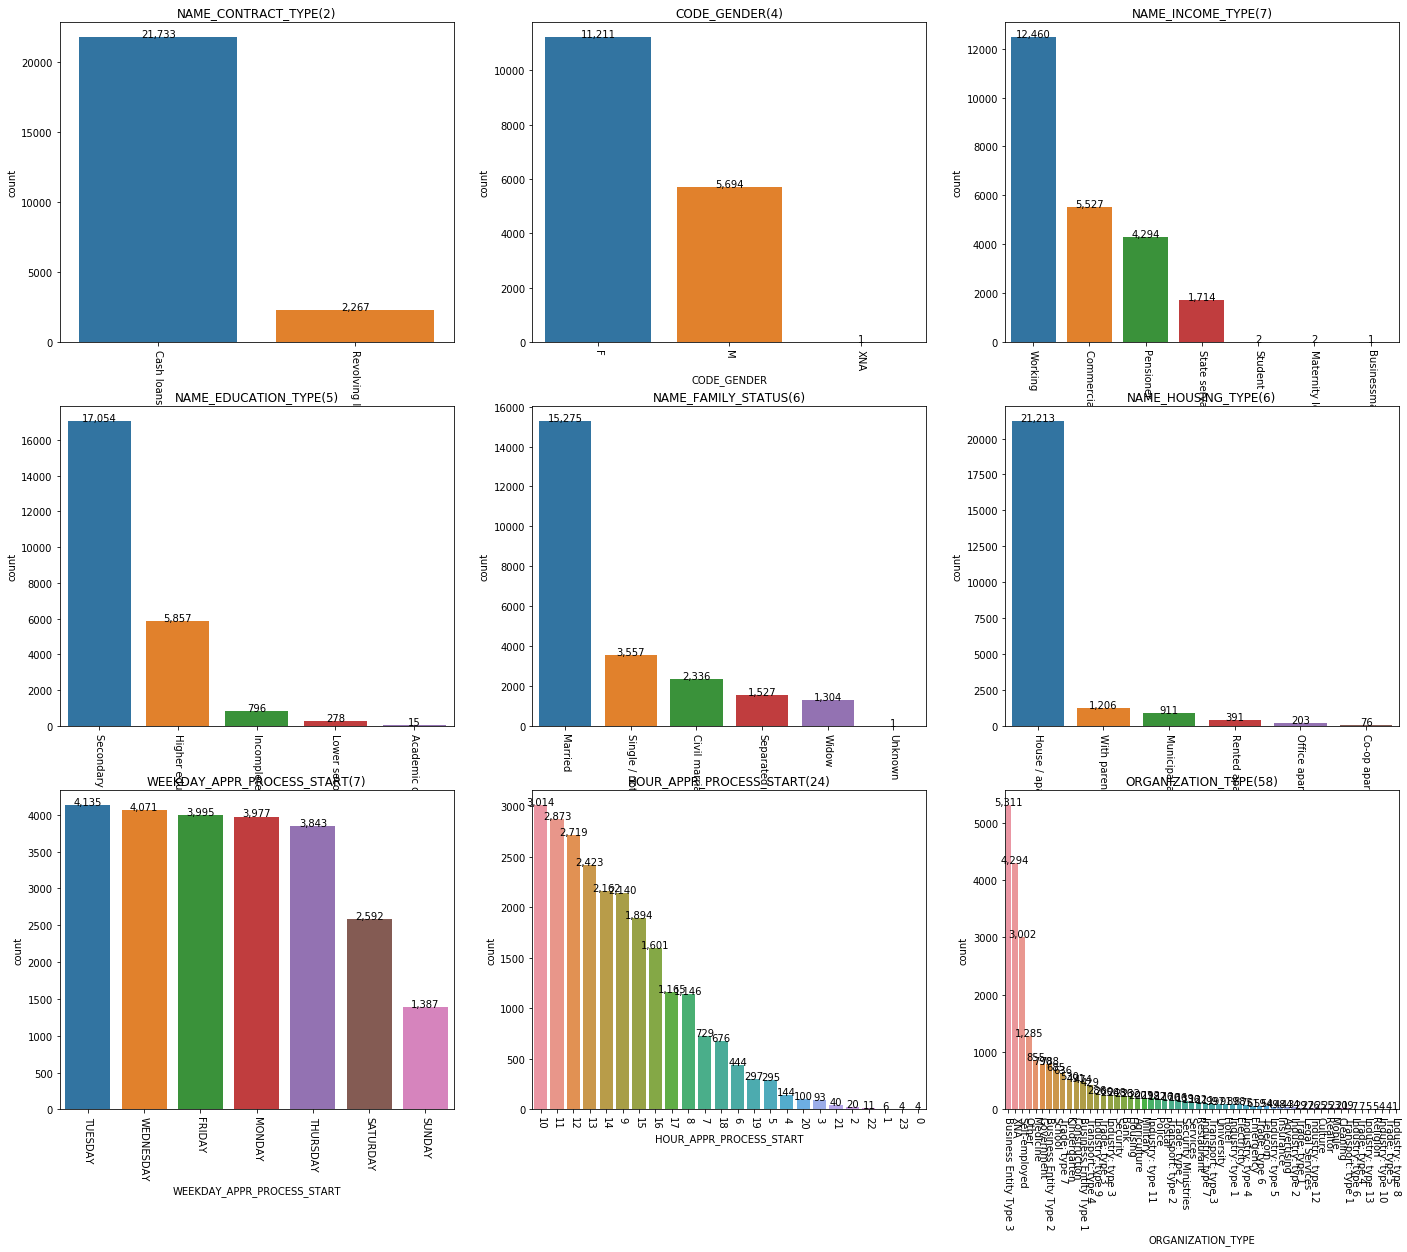

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(24,20))

for row in range(3):
    for col in range(3):
        idx = row *3 + col
        if idx < len(obj):
            ax  = axes[row][col]
            val = obj[idx]
            sns.countplot(x=val, data=df, order=df[val].value_counts().index, ax=ax).set(title=f"{val}({len(df[val].unique())})") 
            ax.set(xlabel=val)                 
            ax.tick_params(axis='x', labelsize=10, rotation=270)
            for p in ax.patches:
                ax.text(p.get_x() + (p.get_width()/2),  # 가로 위치
                        p.get_y() +  p.get_height()  ,  # 세로 위치  
                        f"{p.get_height():,.0f}"     ,  # 값
                        ha = 'center')                  # 좌우정렬 중간으로
plt.show()

> <span style="color:darkblue;background-color:#fff5b1"> **범주형Cols 분포** </span>  <br>
> -> 문자형 데이터 중 순서가 없는 컬럼 <br>
> -> NAME_CONTRACT_TYPE 을 제외하고는 value가 3개이상임. <br>
> -> 한쪽으로 치우쳐진 변수도 존재함. (NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE)

### ㅇ 수치형(bool(13))

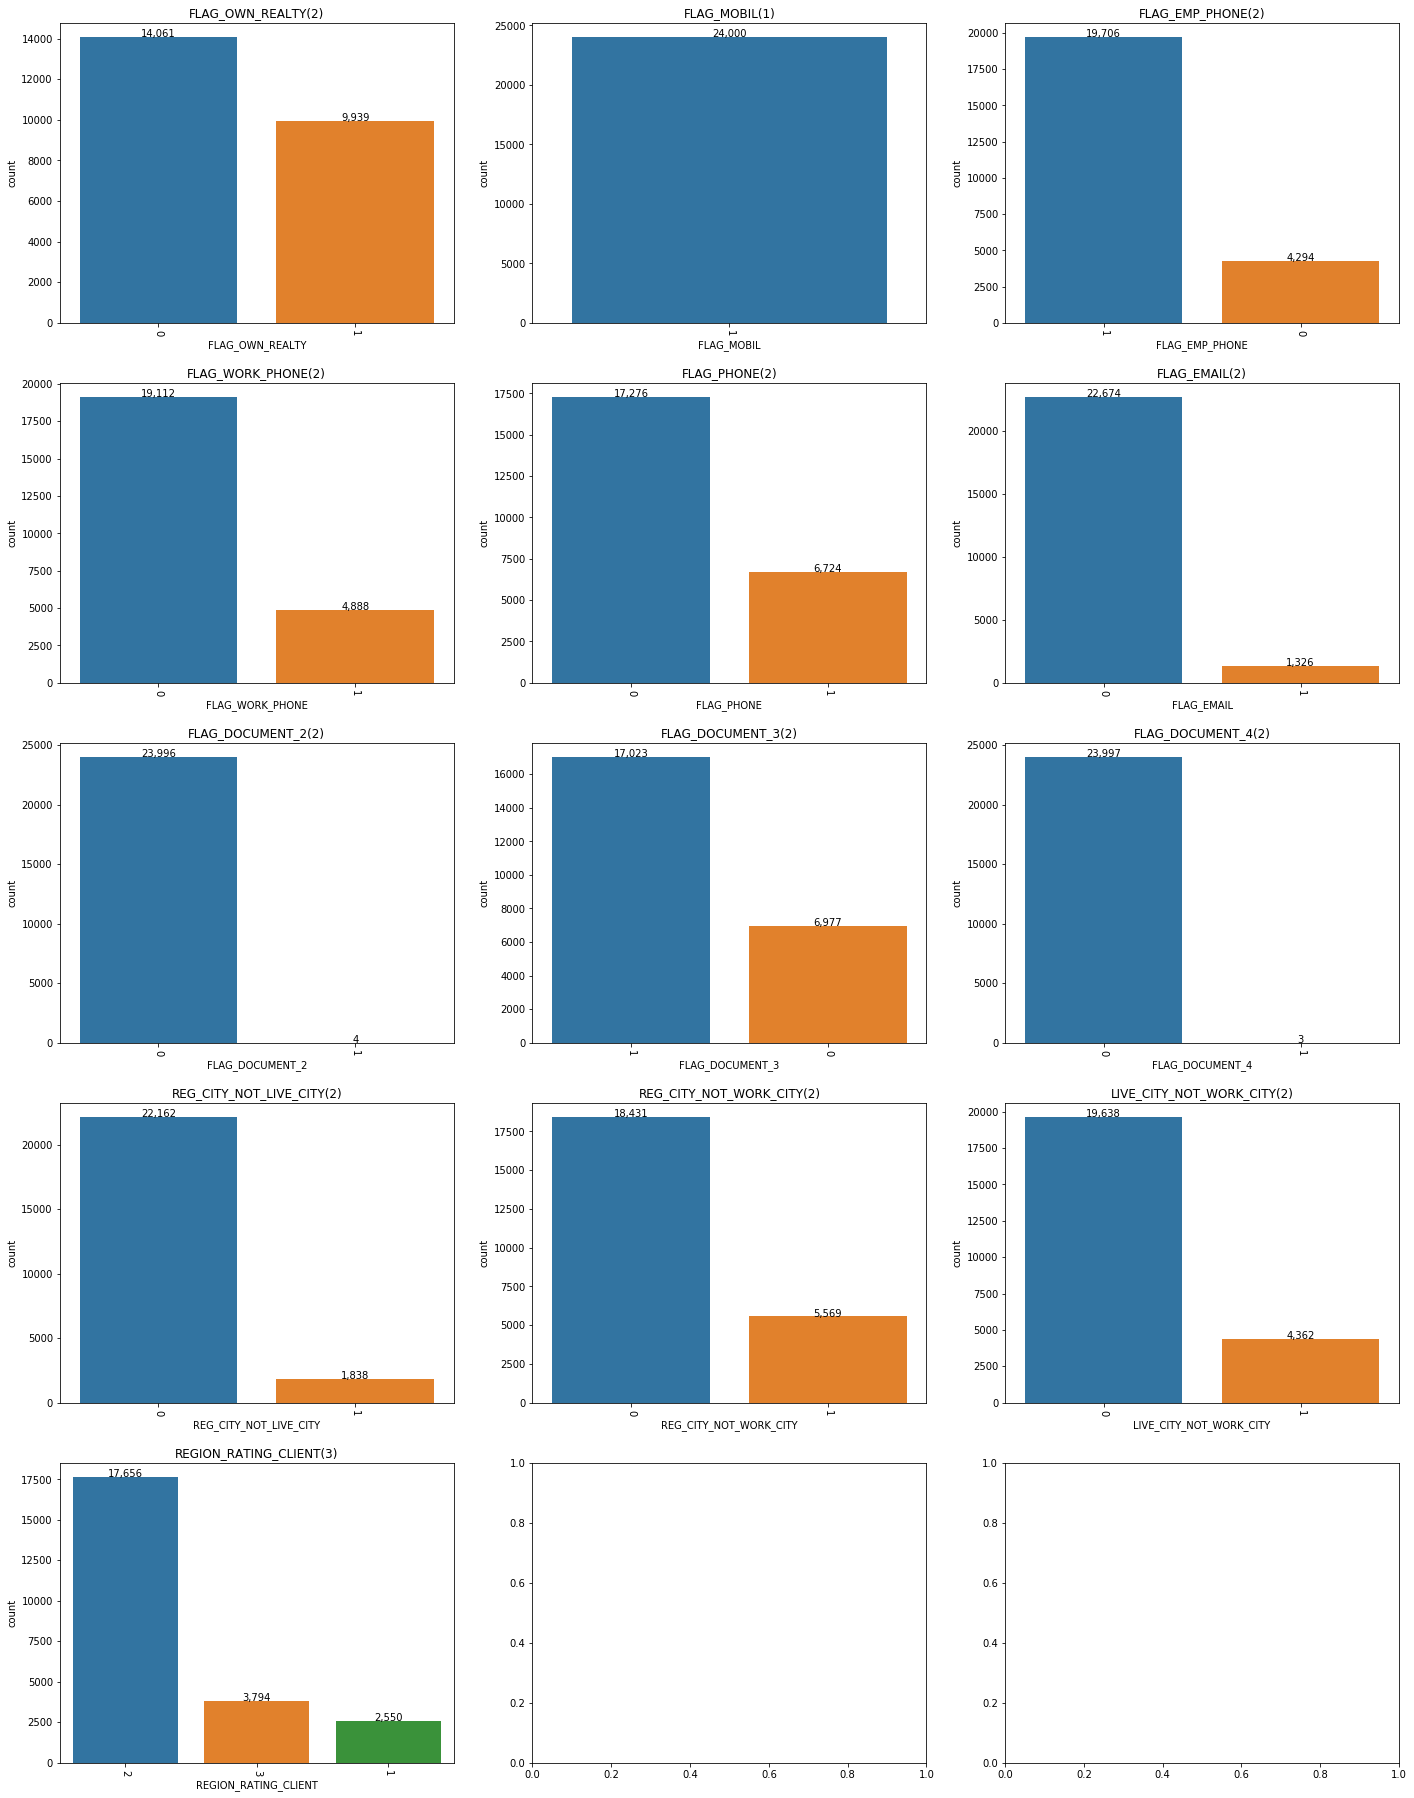

In [27]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(24,32))

for row in range(5):
    for col in range(3):
        idx = row *3 + col
        if idx < len(bol):
            ax  = axes[row][col]
            val = bol[idx]
            sns.countplot(x=val, data=df, order=df[val].value_counts().index, ax=ax).set(title=f"{val}({len(df[val].unique())})") 
            ax.set(xlabel=val)                 
            ax.tick_params(axis='x', labelsize=10, rotation=270)
            for p in ax.patches:
                ax.text(p.get_x() + (p.get_width()/2),  # 가로 위치
                        p.get_y() +  p.get_height()  ,  # 세로 위치  
                        f"{p.get_height():,.0f}"     ,  # 값
                        ha = 'center')                  # 좌우정렬 중간으로
plt.show()

> <span style="color:darkblue;background-color:#fff5b1"> **수치형Cols 분포** </span>  <br>
> -> REGION_RATING_CLIENT을 제외한 나머지 컬럼들은 여부(0,1)로 이루어짐. <br>
> -> FLAG_MOBIL 컬럼은 모든 데이터가 1임. <br>
> -> 한쪽으로 치우쳐진 변수도 존재함. (FLAG_DOCUMENT_2, FLAG_DOCUMENT_4)

### ㅇ 연속형(f64(11))

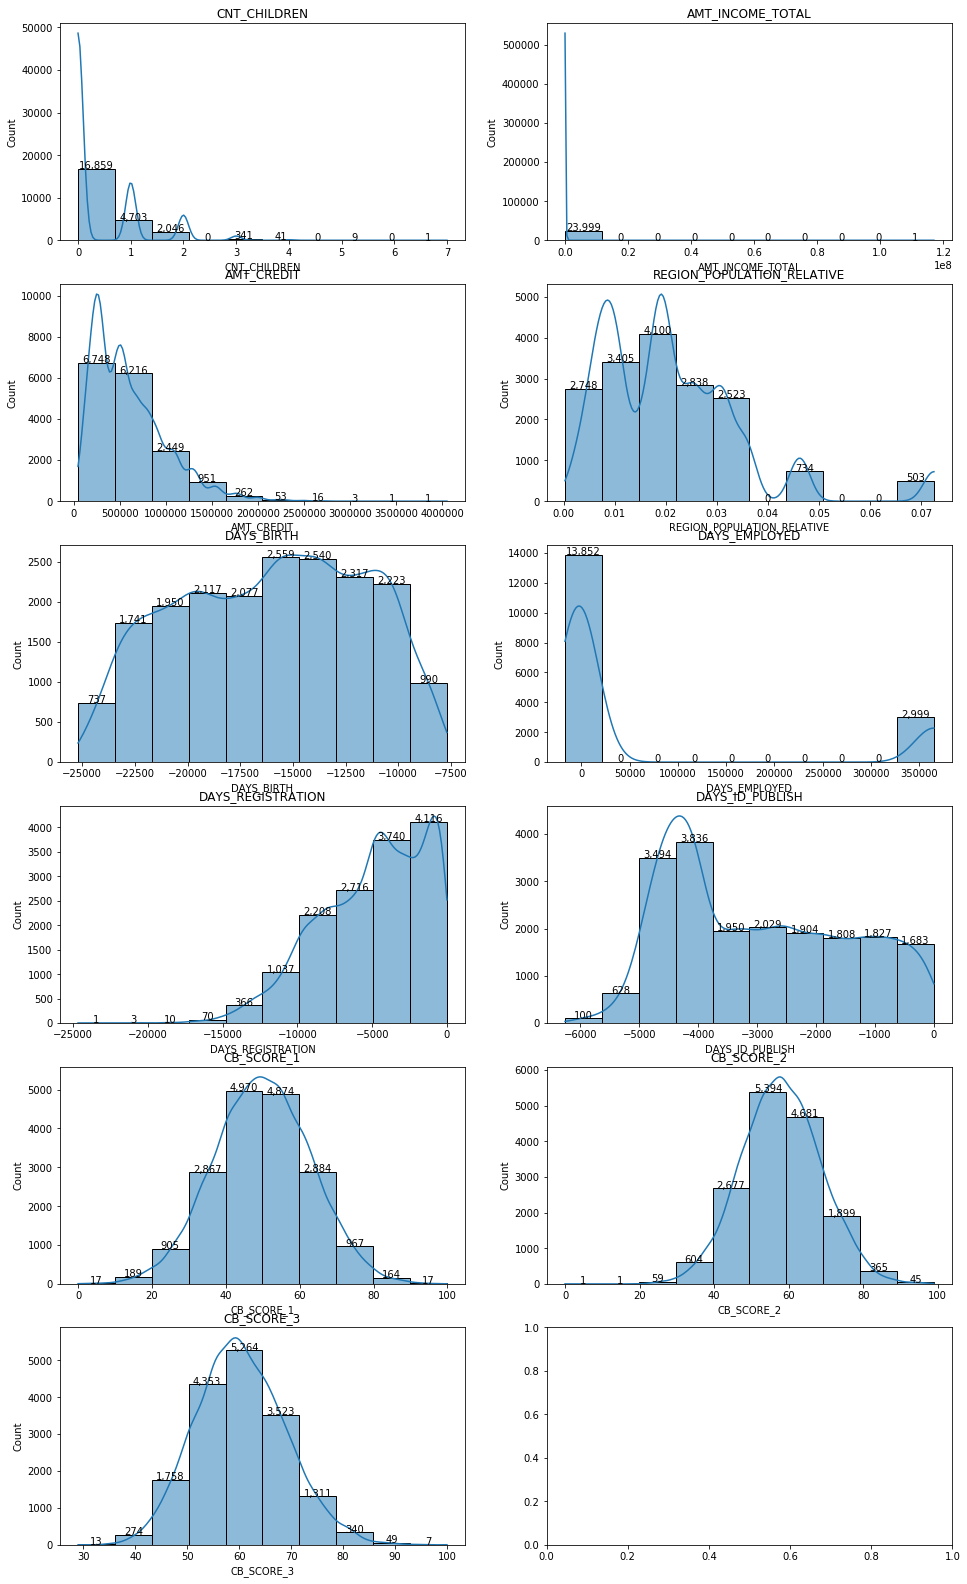

In [28]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(16,28))

for row in range(6):
    for col in range(2):
        idx = row *2 + col
        if idx < len(f64):
            ax  = axes[row][col]
            val = f64[idx]
            sns.histplot(df[val], kde=True, bins=10, ax=ax).set(title=f"{val}")  # kde : 스무딩 선
            ax.set(xlabel=val)
            for p in ax.patches:
                ax.text(p.get_x() + (p.get_width()/2),  # 가로 위치
                        p.get_y() +  p.get_height()  ,  # 세로 위치  
                        f"{p.get_height():,.0f}"     ,  # 값
                        ha = 'center')                  # 좌우정렬 중간으로
plt.show()

> <span style="color:darkblue;background-color:#fff5b1"> **연속형Cols 분포** </span>  <br>
> -> 이상치 존재 : AMT_INCOME_TOTOAL, AMT_CREDIT, REGION_POPULATION_RELATIVE, DAYS_EMPLOYED <br>
> -> 이상치가 존재하는 변수는 별도 처리 필요해보임.

----

> ## 2-6. Cols 특성 
>   - Cols 특성 확인 (3-5. Cols분포를 통해 추가 확인 필요한 컬럼 특성 확인)

>> ### ㅇ 범주형(obj)

* NAME_CONTRACT_TYPE(2) : 대출종류(Cashloans: 일반 대출, Revolvingloans: 마이너스 대출)

In [29]:
df.groupby([obj[0]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,NAME_CONTRACT_TYPE,cnt
0,Cash loans,21733
1,Revolving loans,2267


* CODE_GENDER(4) : 성별 <br>
   **NaN, XNA ==> 별도 상수("null")로 변환 필요**

In [30]:
df.groupby([obj[1]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,CODE_GENDER,cnt
0,F,11211
1,NaN,7094
2,M,5694
3,XNA,1


* NAME_INCOME_TYPE(7) : 소득 유형

In [31]:
df.groupby([obj[2]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,NAME_INCOME_TYPE,cnt
0,Working,12460
1,Commercial associate,5527
2,Pensioner,4294
3,State servant,1714
4,Maternity leave,2
5,Student,2
6,Businessman,1


* NAME_EDUCATION_TYPE(5) : 학력

In [32]:
df.groupby([obj[3]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,NAME_EDUCATION_TYPE,cnt
0,Secondary / secondary special,17054
1,Higher education,5857
2,Incomplete higher,796
3,Lower secondary,278
4,Academic degree,15


* NAME_FAMILY_STATUS(6) : 결혼 상태 <br>
   **현재결혼여부 NewCol 생성 필요 (NOW_MARRYED_YN)**

In [33]:
df.groupby([obj[4]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,NAME_FAMILY_STATUS,cnt
0,Married,15275
1,Single / not married,3557
2,Civil marriage,2336
3,Separated,1527
4,Widow,1304
5,Unknown,1


In [34]:
df["NOW_MARRYED_YN"] = [1 if marryyn == "Married" else 0 for marryyn in df.NAME_FAMILY_STATUS]

In [35]:
df.groupby(["NOW_MARRYED_YN"],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,NOW_MARRYED_YN,cnt
0,1,15275
1,0,8725


* NAME_HOUSING_TYPE(6) : 주거 형태

In [36]:
df.groupby([obj[5]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,NAME_HOUSING_TYPE,cnt
0,House / apartment,21213
1,With parents,1206
2,Municipal apartment,911
3,Rented apartment,391
4,Office apartment,203
5,Co-op apartment,76


* WEEKDAY_APPR_PROCESS_START(3) : 대출 신청 요일 <br>
   **Weekday, Weekend NewCol 생성 필요 (WEEKYN)**

In [37]:
df.groupby([obj[6]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,WEEKDAY_APPR_PROCESS_START,cnt
0,TUESDAY,4135
1,WEDNESDAY,4071
2,FRIDAY,3995
3,MONDAY,3977
4,THURSDAY,3843
5,SATURDAY,2592
6,SUNDAY,1387


In [38]:
df["WEEKYN"] = ["N" if (day=="SATURDAY")|(day=="SUNDAY") else "Y" for day in df.WEEKDAY_APPR_PROCESS_START]

In [39]:
df.groupby(["WEEKYN"],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,WEEKYN,cnt
0,Y,20021
1,N,3979


* HOUR_APPR_PROCESS_START(24) : 대출 신청 시간대 <br>
   **오전/오후, 아침/점심/저녁/밤 NewCol 생성 필요 (AMYN,TIME_TYPE)**

In [40]:
df.groupby([obj[7]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,HOUR_APPR_PROCESS_START,cnt
0,10,3014
1,11,2873
2,12,2719
3,13,2423
4,14,2162
5,9,2140
6,15,1894
7,16,1601
8,17,1165
9,8,1146


In [41]:
df["AMYN"] = [0 if time in(["13","14","15","16","17","18","19","20","21","22","23","0"]) else 1 for time in df.HOUR_APPR_PROCESS_START]
df["TIME_TYPE"] = [1 if time in(["5","6","7","8","9","10"]) else 2 if time in(["11","12","13","14","15","16"]) else 3 if time in(["17","18","19","20","21","22"]) else 4 for time in df.HOUR_APPR_PROCESS_START]

In [42]:
df.groupby(["AMYN"],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,AMYN,cnt
0,1,13623
1,0,10377


In [43]:
df.groupby(["TIME_TYPE"],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,TIME_TYPE,cnt
0,2,13672
1,1,7768
2,3,2289
3,4,271


* ORGANIZATION_TYPE(58) : 근무 회사 유형 <br>
   **NaN ==> 별도 상수("null")로 변환 필요** <br>
   **type 상위별 집계하여 NewCol 생성 필요 (ORGAN_MID_TYPE)**

In [44]:
df.groupby([obj[8]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,ORGANIZATION_TYPE,cnt
0,Business Entity Type 3,5311
1,XNA,4294
2,Self-employed,3002
3,Other,1285
4,Medicine,855
5,Government,790
6,Business Entity Type 2,788
7,School,685
8,Trade: type 7,636
9,Kindergarten,530


In [45]:
df["ORGAN_MID_TYPE"] = ["Business Entity" if "Business Entity" in organ else "Industry" if "Industry" in organ else "Trade" if "Trade" in organ else "Transport" if "Transport" in organ else organ for organ in df.ORGANIZATION_TYPE]

In [46]:
df.groupby(["ORGAN_MID_TYPE"],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,ORGAN_MID_TYPE,cnt
0,Business Entity,6573
1,XNA,4294
2,Self-employed,3002
3,Other,1285
4,Trade,1161
5,Industry,1135
6,Medicine,855
7,Government,790
8,Transport,717
9,School,685


---

> <span style="color:darkblue;background-color:#fff5b1"> **Cols 특성(범주형)** </span>  <br>
> -> **결측치 처리[2]  : CODE_GENDER, ORGANIZATION_TYPE** <br>
> -> **NewCol 생성필요** <br>

---

>> ### ㅇ 수치형(bol)

* FLAG_OWN_REALTY(3) : 자가부동산 보유 여부 <br>
   **"Y" ==> 1, "N" ==> 0 으로 변환 필요(Flag 형태)**

In [47]:
df.groupby([bol[0]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,FLAG_OWN_REALTY,cnt
0,0,14061
1,1,9939


* FLAG_MOBIL(1) : 휴대폰 번호 등록 여부 <br>
   **데이터가 전부 1이라 삭제 필요**

In [48]:
df.groupby([bol[1]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,FLAG_MOBIL,cnt
0,1,24000


* FLAG_EMP_PHONE(2) : 고용주 연락처 등록 여부

In [49]:
df.groupby([bol[2]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,FLAG_EMP_PHONE,cnt
0,1,19706
1,0,4294


* FLAG_WORK_PHONE(2) : 직장 전화번호 등록 여부

In [50]:
df.groupby([bol[3]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,FLAG_WORK_PHONE,cnt
0,0,19112
1,1,4888


* FLAG_PHONE(2) : 집 전화번호 등록 여부

In [51]:
df.groupby([bol[4]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,FLAG_PHONE,cnt
0,0,17276
1,1,6724


* FLAG_EMAIL(2) : 이메일 주소 등록 여부

In [52]:
df.groupby([bol[5]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,FLAG_EMAIL,cnt
0,0,22674
1,1,1326


* FLAG_DOCUMENT_2(2) : 문서 2 제공 여부

In [53]:
df.groupby([bol[6]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,FLAG_DOCUMENT_2,cnt
0,0,23996
1,1,4


* FLAG_DOCUMENT_3(2) : 문서 3 제공 여부

In [54]:
df.groupby([bol[7]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,FLAG_DOCUMENT_3,cnt
0,1,17023
1,0,6977


* FLAG_DOCUMENT_4(2) : 문서 4 제공 여부

In [55]:
df.groupby([bol[8]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,FLAG_DOCUMENT_4,cnt
0,0,23997
1,1,3


* REG_CITY_NOT_LIVE_CITY(2) : 고객의 등록지 주소와 실거주지 일치 여부

In [56]:
df.groupby([bol[9]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,REG_CITY_NOT_LIVE_CITY,cnt
0,0,22162
1,1,1838


* REG_CITY_NOT_WORK_CITY(2) : 고객의 등록지 주소와 직장 주소 일치 여부

In [57]:
df.groupby([bol[10]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,REG_CITY_NOT_WORK_CITY,cnt
0,0,18431
1,1,5569


* LIVE_CITY_NOT_WORK_CITY(2) : 고객의 실거주지와 직장 주소 일치 여부

In [58]:
df.groupby([bol[11]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,LIVE_CITY_NOT_WORK_CITY,cnt
0,0,19638
1,1,4362


* REGION_RATING_CLIENT(3) : 거주지 등급

In [59]:
df.groupby([bol[12]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,REGION_RATING_CLIENT,cnt
0,2,17656
1,3,3794
2,1,2550


---

> <span style="color:darkblue;background-color:#fff5b1"> **Cols 특성(수치형)** </span>  <br>
> -> **데이터 변환[1]  : FLAG_OWN_REALTY** <br>
> -> **Column 삭제[1]  : FLAG_MOBIL** <br>

---

>> ### ㅇ 연속형(f64)
>>   1) 공백처리
>>   2) 이상치처리

In [60]:
# 공백처리
def NvalS(df):
    # 연속형 null처리 (knn: 2)
    imputer = KNNImputer(n_neighbors=2)
    imputer.fit(df[f64])
    return pd.DataFrame(imputer.transform(df[f64]),columns=df[f64].columns)

# 이상치처리
def Outliers_IQR(df):
    colO = ["AMT_INCOME_TOTAL","AMT_CREDIT","REGION_POPULATION_RELATIVE","DAYS_EMPLOYED","DAYS_REGISTRATION"]
    for col in colO:
        # IQR기반으로 upper,lower 찾기 -> train data로 fit
        quartile_1, quartile_3 = np.percentile(df[col], [25,75])
        iqr = quartile_3 - quartile_1
        lower = quartile_1 - (iqr * 1.5)
        upper = quartile_3 + (iqr * 1.5)         
        # train data로 fit 된 lower,upper value transform
        if col == colO[0]:
            l = pd.DataFrame([upper if val>upper else lower if val<lower else val for val in df[col]]).rename(columns={0:col})    
        else:  
            l = pd.concat([l,pd.DataFrame([upper if val>upper else lower if val<lower else val for val in df[col]]).rename(columns={0:col})],axis=1)
    df = pd.concat([df[list(df.columns.difference(colO))],l],axis=1)
    return df

# 연속형 차트
def histogram(val):
    sns.histplot(val, bins=20).set(title="Histogram")
    return plt.show()
def boxplot(val):
    plt.boxplot(val, whis=1.5)  # IQR에 곱할 수
    return plt.show()
def NumDetail(val):
    histogram(val)
    boxplot(val)

In [61]:
# null값 처리 (연속형)
numberic  = NvalS(df)
# 이상치 처리 (IQR)
numberic2 = Outliers_IQR(numberic)

* CNT_CHILDREN(3) : 자녀수 <br>
   **자녀여부 NewCol 생성 필요 (HAVE_CHILD_YN)**

In [62]:
df.groupby([f64[0]],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,CNT_CHILDREN,cnt
0,0.0,16859
1,1.0,4703
2,2.0,2046
3,3.0,341
4,4.0,41
5,5.0,9
6,7.0,1


In [63]:
df["HAVE_CHILD_YN"] = [1 if cnt_child != 0 else 0 for cnt_child in df.CNT_CHILDREN]

In [64]:
df.groupby(["HAVE_CHILD_YN"],dropna=False).agg(cnt = ("SK_ID_CURR","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,HAVE_CHILD_YN,cnt
0,0,16859
1,1,7141


* AMT_INCOME_TOTAL : 소득 금액(USD) <br>
   **이상치처리 필요**

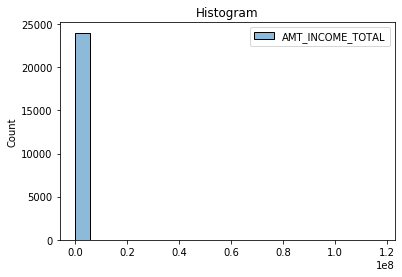

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fa29da632f0> (for post_execute):


KeyboardInterrupt: 

In [66]:
NumDetail(numberic[[f64[1]]])

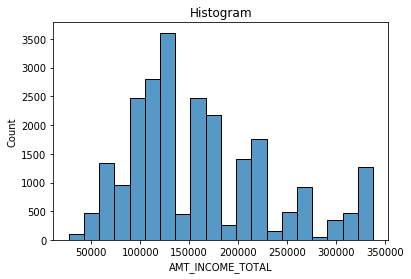

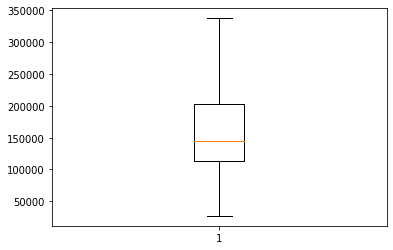

In [67]:
NumDetail(numberic2[f64[1]])

* AMT_CREDIT : 신용대출 금액(USD) <br>
   **공백 및 이상치 처리 필요**

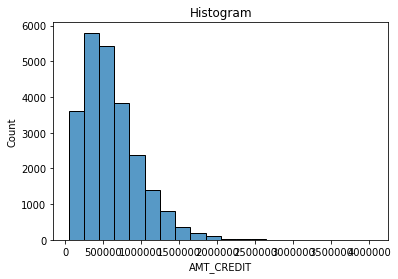

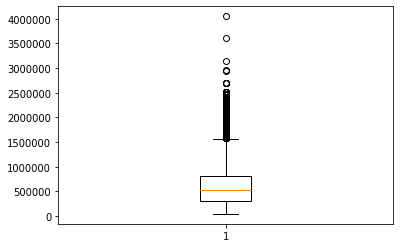

In [68]:
NumDetail(numberic[f64[2]])

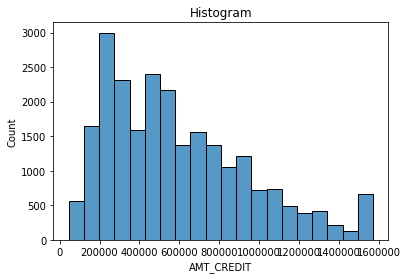

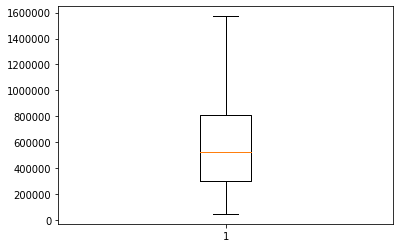

In [69]:
NumDetail(numberic2[f64[2]])

* REGION_POPULATION_RELATIVE : 거주 지역의 표준화된 인구 <br>
   **공백 및 이상치 처리 필요**

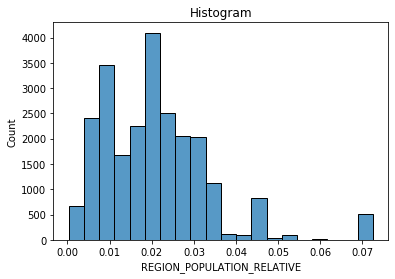

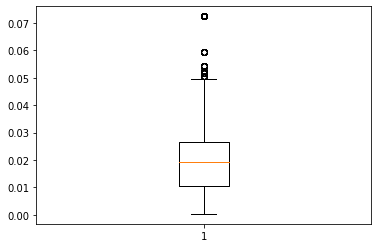

In [70]:
NumDetail(numberic[f64[3]])

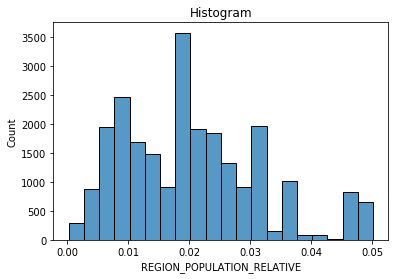

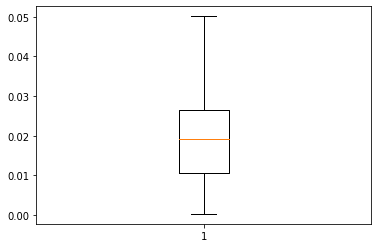

In [71]:
NumDetail(numberic2[f64[3]])

* DAYS_BIRTH : 대출 신청 시점에서의 일단위 나이(기준 시점 대비 상대적인 시간) <br>
   **DAYS_BIRTH 양수로 변환 필요 (현재 전부 음수)** <br>
   **연령, 연령대 NewCol 생성 필요 (AGE,AGE_RNG)**

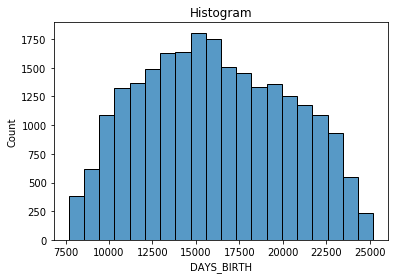

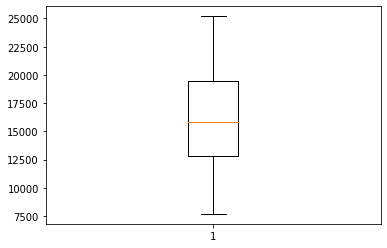

In [72]:
NumDetail(numberic[f64[4]]*-1)

In [73]:
numberic["AGE"] = [int(birth*-1/365) for birth in numberic.DAYS_BIRTH]
numberic["AGE_RNG"] = [int(age/10)*10 for age in numberic.AGE]

In [74]:
numberic.groupby(["AGE"],dropna=False).agg(cnt = ("AMT_CREDIT","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,AGE,cnt
0,43,783
1,41,761
2,40,757
3,42,753
4,37,711
5,36,689
6,44,685
7,38,677
8,39,673
9,47,663


In [75]:
numberic.groupby(["AGE_RNG"],dropna=False).agg(cnt = ("AMT_CREDIT","count")).reset_index().sort_values(["cnt"],ascending=[False]).reset_index(drop=True)

,AGE_RNG,cnt
0,40,6815
1,30,6337
2,50,5280
3,20,3009
4,60,2559


* DAYS_EMPLOYED : 대출 신청 시점에서의 고객의 근무일수(기준 시점 대비 상대적인 시간) <br>
   **공백 및 이상치 처리 필요**

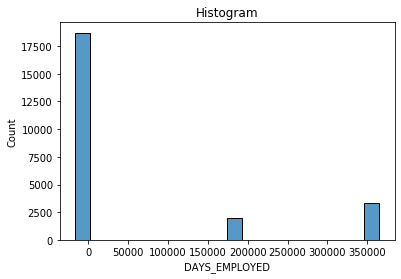

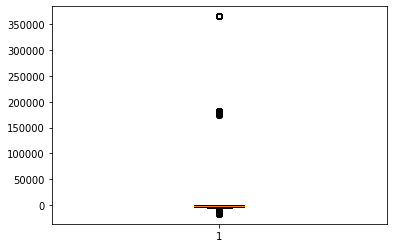

In [76]:
NumDetail(numberic[f64[5]])

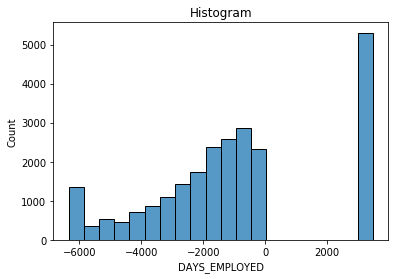

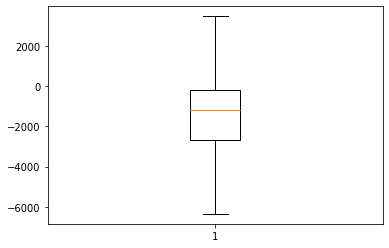

In [77]:
NumDetail(numberic2[f64[5]])

* DAYS_REGISTRATION : 대출 신청 이전에 고객이 등록정보를 변경한 시점 사이의 일수(기준 시점 대비 상대적인 시간) <br>
   **공백 및 이상치 처리 필요**

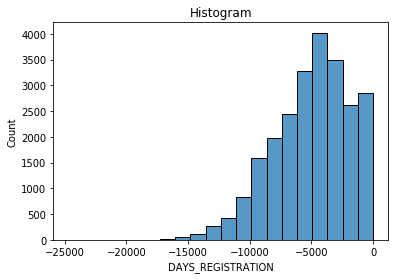

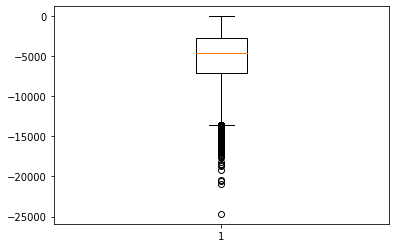

In [78]:
NumDetail(numberic[f64[6]])

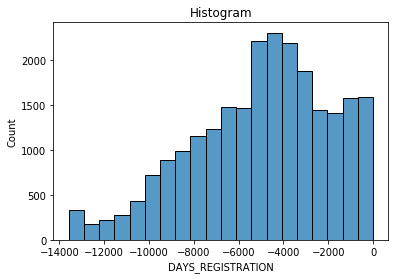

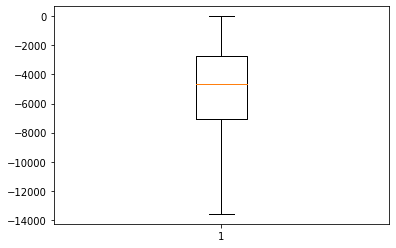

In [79]:
NumDetail(numberic2[f64[6]])

* DAYS_ID_PUBLISH : 대출 신청 이전에 고객이 신분증을 변경한 시점 사이의 일수(기준 시점 대비 상대적인 시간) <br>
   **공백 처리 필요**

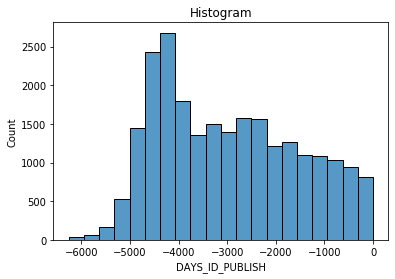

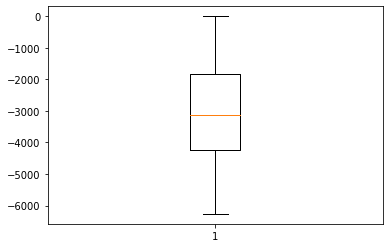

In [80]:
NumDetail(numberic[f64[7]])

* CB_SCORE_1 : 신용점수 1 <br>
   **공백 처리 필요**

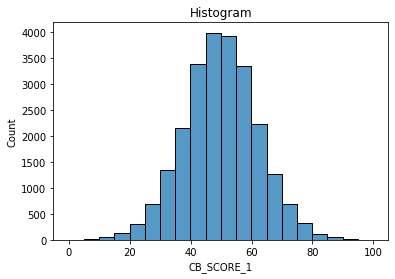

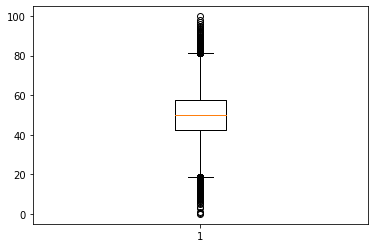

In [81]:
NumDetail(numberic[f64[8]])

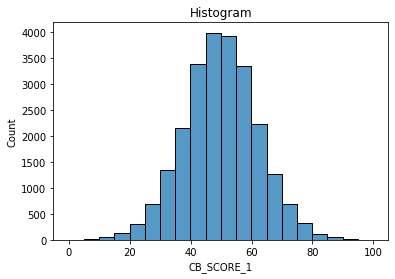

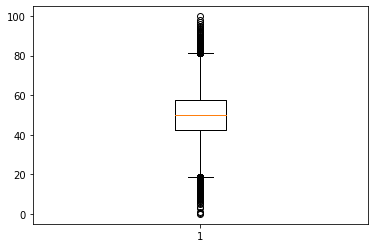

In [82]:
NumDetail(numberic2[f64[8]])

* CB_SCORE_2 : 신용점수 2 <br>
   **공백 처리 필요**

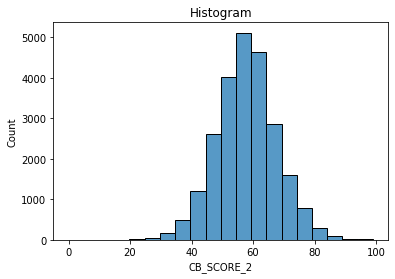

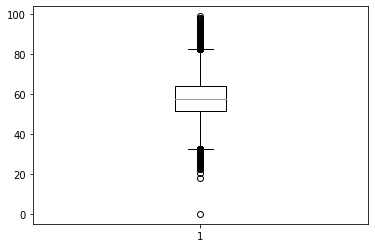

In [83]:
NumDetail(numberic[f64[9]])

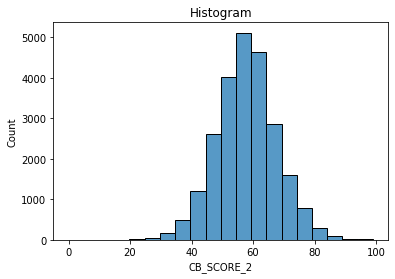

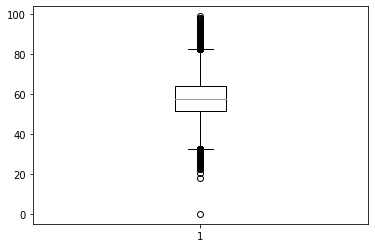

In [84]:
NumDetail(numberic2[f64[9]])

* CB_SCORE_3 : 신용점수 3 <br>
   **공백 처리 필요**

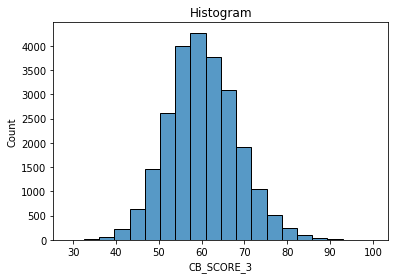

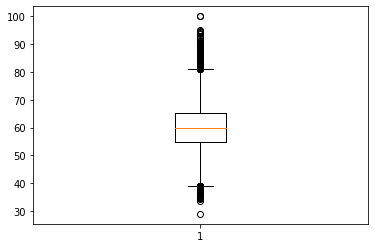

In [85]:
NumDetail(numberic[f64[10]])

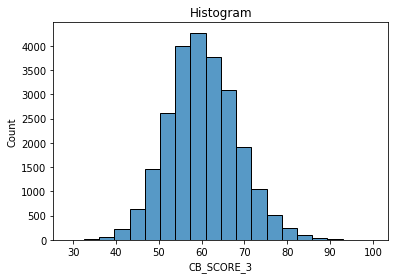

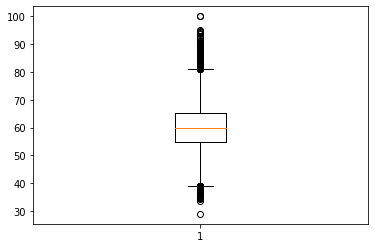

In [86]:
NumDetail(numberic2[f64[10]])

> <span style="color:darkblue;background-color:#fff5b1"> **Cols 특성(연속형)** </span>  <br>
> -> **결측치 처리(9) : AMT_CREDIT, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, CB_SCORE_1, CB_SCORE_2, CB_SCORE_3** <br>
> -> **이상치 처리(5) : AMT_INCOME_TOTAL, AMT_CREDIT, REGION_POPULATION_RELATIVE, DAYS_EMPLOYED, DAYS_REGISTRATION** <br>
> -> **NewCol 생성(1)  : DAYS_BIRTH** <br>

----

# 3. Feature Engineering
  - EDA 활용하여 Data Reshape
  - Train data Fit ==> Test data Transform

> ## 3-1. Cols DType (특성별 분류)

In [87]:
def Dtype(df):
    # obj, i64, f64 분류 (SK_ID_CURR, TARGET 제외)
    obj = [col for col in df.columns if (df[col].dtypes == "object") &(col != "SK_ID_CURR")&(col != "TARGET")]  # 9개
    i64 = [col for col in df.columns if (df[col].dtypes == "int64")  &(col != "SK_ID_CURR")&(col != "TARGET")]  # 14개
    f64 = [col for col in df.columns if (df[col].dtypes == "float64")&(col != "SK_ID_CURR")&(col != "TARGET")]  # 10개

    # i64 cols to string
    for colI in i64:
        df[colI] = df[colI].astype(str)
    # string values 특수문자 제거
    for colO in obj:
        df[colO] = df[colO].str.replace(pat=r'[^\w]',repl=r'',regex=True)
    # FLAG_OWN_REALTY (Y,N ==> 1,0) 전환
    df.FLAG_OWN_REALTY = [1 if realty == "Y" else 0 if realty == "N" else 0 for realty in df.FLAG_OWN_REALTY]    
    # CNT_CHILDREN to float64
    df.CNT_CHILDREN = df.CNT_CHILDREN.astype('float64')
    # CB_SCORE 0점 Null처리 (결측치 처리를 위한)
    df.CB_SCORE_1 = [np.nan if scr1 == 0 else scr1 for scr1 in df.CB_SCORE_1]
    df.CB_SCORE_2 = [np.nan if scr2 == 0 else scr2 for scr2 in df.CB_SCORE_2]
    df.CB_SCORE_3 = [np.nan if scr3 == 0 else scr3 for scr3 in df.CB_SCORE_3]
    # DAYS_EMPLOYED 이상치(365243) Null처리
    df.DAYS_EMPLOYED = [np.nan if employed == 365243 else employed for employed in df.DAYS_EMPLOYED]
    
    # dtype(bool)
    bol = [col for col in df.columns if "FLAG_" in col] + [col for col in df.columns if "REG_" in col] + ["LIVE_CITY_NOT_WORK_CITY","REGION_RATING_CLIENT"]
    # bool cols to int64
    for colB in bol:
        df[colB] = df[colB].astype('int64')
    
    return df

> <span style="color:darkblue;background-color:#fff5b1"> **Cols DType** </span>  <br>
> -> **bool(13)    : FLAG_MOBIL, FLAG_DOCUMENT_2, REGION_RATING_CLIENT, REG_CITY_NOT_LIVE_CITY 등** <br>
> -> **object(9)   : NAME_CONTRACT_TYPE, CODE_GENDER, ORGANIZATION_TYPE, NAME_INCOME_TYPE 등** <br>
> -> **float64(11) : CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, DAYS_BIRTH, CB_SCORE_1 등** <br>
> -> **int64(2)    : TARGET, SK_ID_CURR**

----

> ## 3-2. Null values 처리 (결측치 처리)
>   - 1. 범주형 데이터(obj)
>     - NA를 결측치 그대로 처리
>   - 2. 수치형 데이터(bool)
>     - NA를 0 으로 치환
>   - 3. 연속형 데이터(f64)
>     - KNN 대체 (인접한값 추정치)

In [88]:
def NvalS(dfN,dfT):
    bol = [col for col in dfN.columns if "FLAG_" in col] + [col for col in dfN.columns if "REG_" in col] + ["LIVE_CITY_NOT_WORK_CITY","REGION_RATING_CLIENT"]
    obj = [col for col in dfN.columns if (dfN[col].dtypes == "object") &(col != "SK_ID_CURR")&(col != "TARGET")]
    f64 = [col for col in dfN.columns if (dfN[col].dtypes == "float64")&(col != "SK_ID_CURR")&(col != "TARGET")]

    # 1. 범주형(obj) null처리
    n1 = dfT[obj].fillna("Null").replace("XNA","Null").reset_index(drop=True)
    # 2. 수치형(bool) null처리
    n2 = dfT[bol].fillna(0).reset_index(drop=True)
    # 3. 연속형 null처리 (knn: 2)
    imputer = KNNImputer(n_neighbors=2)
    imputer.fit(dfT[f64])
    n3 = pd.DataFrame(imputer.transform(dfT[f64]),columns=dfT[f64].columns)
    # 통합
    df = pd.concat([n1,n2,n3],axis=1)
    return df

> <span style="color:darkblue;background-color:#fff5b1"> **결측치 Cols** </span>  <br>
> -> **범주형(object) : 결측치 그대로(Null) 처리** <br>
> -> **범주형(bool)   : 결측치 0으로 변환** <br>
> -> **연속형(f64)    : KNN(추정치) 인접한 데이터 평균으로 대체** <br>

----

> ## 3-3. Outlier(이상치) 처리
>   - IQR 방식 (Q1-1.5IQR 보다 작거나, Q3+1.5IQR 보다 큰 데이터는 이상치 처리) 
>     - 이상치 값은 근접한 값으로 대체

In [89]:
def Outliers_IQR(dfN,dfT):
    colO = ["AMT_INCOME_TOTAL","AMT_CREDIT","REGION_POPULATION_RELATIVE","DAYS_EMPLOYED","DAYS_REGISTRATION"]
    
    for col in colO:
        # IQR기반으로 upper,lower 찾기 -> train data로 fit
        quartile_1, quartile_3 = np.percentile(dfN[col], [25,75])
        iqr = quartile_3 - quartile_1
        lower = quartile_1 - (iqr * 1.5)
        upper = quartile_3 + (iqr * 1.5)         
        # train data로 fit 된 lower,upper value transform
        if col == colO[0]:
            l = pd.DataFrame([upper if val>upper else lower if val<lower else val for val in dfT[col]]).rename(columns={0:col})    
        else:  
            l = pd.concat([l,pd.DataFrame([upper if val>upper else lower if val<lower else val for val in dfT[col]]).rename(columns={0:col})],axis=1)
    df = pd.concat([dfT[list(dfT.columns.difference(colO))],l],axis=1)
    return df

> <span style="color:darkblue;background-color:#fff5b1"> **이상치 Cols** </span>  <br>
> -> **연속형 : IQR방식 활용하여 이상치는 근접값으로 치환** <br>
> -> **AMT_INCOME_TOTOAL, AMT_CREDIT, REGION_POPULATION_RELATIVE, DAYS_EMPLOYED, DAYS_REGISTRATION**

----

> ## 3-4. NewCols 생성

In [90]:
def NewCols(dfT):
    # HAVE_CHILD_YN(자녀여부)
    dfT["HAVE_CHILD_YN"]    = [1 if cnt_child > 0 else 0 for cnt_child in dfT.CNT_CHILDREN]
    # NOW_MARRYED_YN(현재결혼상태여부)
    dfT["NOW_MARRYED_YN"]   = [1 if marryyn == "Married" else 0 for marryyn in dfT.NAME_FAMILY_STATUS]
    # WEEKYN(평일여부)
    dfT["WEEKYN"]           = [0 if (day=="SATURDAY")|(day=="SUNDAY") else 1 for day in dfT.WEEKDAY_APPR_PROCESS_START]
    # AMYN(오전여부)
    dfT["AMYN"]             = [0 if time in([13,14,15,16,17,18,19,20,21,22,23,0]) else 1 for time in dfT.HOUR_APPR_PROCESS_START]
    # TIME_TYPE(시간대타입)
    dfT["TIME_TYPE"]        = [1 if time in([5,6,7,8,9,10]) else 2 if time in([11,12,13,14,15,16]) else 3 if time in([17,18,19,20,21,22]) else 4 for time in dfT.HOUR_APPR_PROCESS_START]
    # ORGAN_MID_TYPE(근무회사유형-중분류)
    dfT["ORGAN_MID_TYPE"]   = ["Business Entity" if "Business Entity" in organ else "Industry" if "Industry" in organ else "Trade" if "Trade" in organ else "Transport" if "Transport" in organ else organ for organ in dfT.ORGANIZATION_TYPE]
    # AGE(연령)
    dfT["AGE"]              = [float(int(birth*-1/365)) for birth in dfT.DAYS_BIRTH]
    # AGE_RNG(연령대) 
    dfT["AGE_RNG"]          = [str(int(age/10)*10) for age in dfT.AGE]
    # FAMILY_CNT(가족구성원수)
    dfT["CNT_FAMILY"]       = [child+2 if marryYN == 1 else child+1 for child,marryYN in zip(dfT.CNT_CHILDREN,dfT.NOW_MARRYED_YN)]
    # PER1_INCOME(1인당소득금액)
    dfT["PER1_INCOME"]      = [income/family    for income,family    in zip(dfT.AMT_INCOME_TOTAL,dfT.CNT_FAMILY)]
    # CREDIT/INCOME(소득대비신용대출비율) 
    dfT["CREDIT/INCOME"]    = [credit/income    for credit,income    in zip(dfT.AMT_CREDIT,dfT.AMT_INCOME_TOTAL)]
    # INCOME-CREDIT(가용자산) 
    dfT["INCOME-CREDIT"]    = [income-credit    for income,credit    in zip(dfT.AMT_INCOME_TOTAL,dfT.AMT_CREDIT)]
    # EMPLOYED/BIRTH(생애대비소득기간비율) 
    dfT["EMPLOYED/BIRTH"]   = [employed/birth   for employed,birth   in zip(dfT.DAYS_EMPLOYED,dfT.DAYS_BIRTH)]
    # INCOME/EMPLOYED(평균소득금액) 
    dfT["INCOME/EMPLOYED"]  = [income/employed  for income,employed  in zip(dfT.AMT_INCOME_TOTAL,dfT.DAYS_EMPLOYED)]
    # INCOME/BIRTH(생애평균소득금액) 
    dfT["INCOME/BIRTH"]     = [income/birth     for income,birth     in zip(dfT.AMT_INCOME_TOTAL,dfT.DAYS_BIRTH)]
    # REGIST/BIRTH(생애대비 고객등록정보 변경일수 비율) 
    dfT["REGIST/BIRTH"]     = [regist/birth     for regist,birth     in zip(dfT.DAYS_REGISTRATION,dfT.DAYS_BIRTH)]
    # REGIST/EMPLOYED(소득일대비 고객등록정보 변경일수 비율) 
    dfT["REGIST/EMPLOYED"]  = [regist/employed  for regist,employed  in zip(dfT.DAYS_REGISTRATION,dfT.DAYS_EMPLOYED)]
    # PUBLISH/BIRTH(생애대비 신분증 변경일수 비율) 
    dfT["PUBLISH/BIRTH"]    = [publish/birth    for publish,birth    in zip(dfT.DAYS_ID_PUBLISH,dfT.DAYS_BIRTH)]
    # PUBLISH/EMPLOYED(소득일대비 신분증 변경일수 비율)
    dfT["PUBLISH/EMPLOYED"] = [publish/employed for publish,employed in zip(dfT.DAYS_ID_PUBLISH,dfT.DAYS_EMPLOYED)]
    
    # DAYS DIFF
    dfT["REGIST-BIRTH"]   = [regist-birth for regist,birth in zip(dfT.DAYS_REGISTRATION,dfT.DAYS_BIRTH)]
    dfT["PUBLISH-BIRTH"]  = [publish-birth for publish,birth in zip(dfT.DAYS_ID_PUBLISH,dfT.DAYS_BIRTH)]
    dfT["EMPLOYED-BIRTH"] = [employed-birth for employed,birth in zip(dfT.DAYS_EMPLOYED,dfT.DAYS_BIRTH)]
    # CB_SCORE 파생변수
    dfT["CBSCORE123_SUM"]   = [cbscore1+cbscore2+cbscore3 for cbscore1,cbscore2,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE123_PROD"]  = [cbscore1*cbscore2*cbscore3 for cbscore1,cbscore2,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE123_WEIGH"] = [cbscore1*2+cbscore2*1+cbscore3*3         for cbscore1,cbscore2,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE123_MEDI"]  = [np.median([cbscore1,cbscore2,cbscore3])  for cbscore1,cbscore2,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE123_MEAN"]  = [np.average([cbscore1,cbscore2,cbscore3]) for cbscore1,cbscore2,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE123_VAR"]   = [np.var([cbscore1,cbscore2,cbscore3])     for cbscore1,cbscore2,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE123_STD"]   = [np.std([cbscore1,cbscore2,cbscore3])     for cbscore1,cbscore2,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE123_MIN"]   = [np.min([cbscore1,cbscore2,cbscore3])     for cbscore1,cbscore2,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE123_MAX"]   = [np.max([cbscore1,cbscore2,cbscore3])     for cbscore1,cbscore2,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE12_SUM"]   = [cbscore1+cbscore2 for cbscore1,cbscore2 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2)]
    dfT["CBSCORE12_SUB"]   = [cbscore1-cbscore2 for cbscore1,cbscore2 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2)]
    dfT["CBSCORE12_PROD"]  = [cbscore1*cbscore2 for cbscore1,cbscore2 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2)]
    dfT["CBSCORE12_MEDI"]  = [np.median([cbscore1,cbscore2])  for cbscore1,cbscore2 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2)]
    dfT["CBSCORE12_MEAN"]  = [np.average([cbscore1,cbscore2]) for cbscore1,cbscore2 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2)]
    dfT["CBSCORE12_VAR"]   = [np.var([cbscore1,cbscore2])     for cbscore1,cbscore2 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2)]
    dfT["CBSCORE12_STD"]   = [np.std([cbscore1,cbscore2])     for cbscore1,cbscore2 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2)]
    dfT["CBSCORE12_MIN"]   = [np.min([cbscore1,cbscore2])     for cbscore1,cbscore2 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2)]
    dfT["CBSCORE12_MAX"]   = [np.max([cbscore1,cbscore2])     for cbscore1,cbscore2 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2)]
    dfT["CBSCORE13_SUM"]   = [cbscore1+cbscore3 for cbscore1,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_3)]
    dfT["CBSCORE13_SUB"]   = [cbscore1-cbscore3 for cbscore1,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_3)]
    dfT["CBSCORE13_PROD"]  = [cbscore1*cbscore3 for cbscore1,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_3)]
    dfT["CBSCORE13_MEDI"]  = [np.median([cbscore1,cbscore3])  for cbscore1,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_3)]
    dfT["CBSCORE13_MEAN"]  = [np.average([cbscore1,cbscore3]) for cbscore1,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_3)]
    dfT["CBSCORE13_VAR"]   = [np.var([cbscore1,cbscore3])     for cbscore1,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_3)]
    dfT["CBSCORE13_STD"]   = [np.std([cbscore1,cbscore3])     for cbscore1,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_3)]
    dfT["CBSCORE13_MIN"]   = [np.min([cbscore1,cbscore3])     for cbscore1,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_3)]
    dfT["CBSCORE13_MAX"]   = [np.max([cbscore1,cbscore3])     for cbscore1,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_3)]
    dfT["CBSCORE23_SUM"]   = [cbscore2+cbscore3 for cbscore2,cbscore3 in zip(dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE23_SUB"]   = [cbscore2-cbscore3 for cbscore2,cbscore3 in zip(dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE23_PROD"]  = [cbscore2*cbscore3 for cbscore2,cbscore3 in zip(dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE23_MEDI"]  = [np.median([cbscore2,cbscore3])  for cbscore2,cbscore3 in zip(dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE23_MEAN"]  = [np.average([cbscore2,cbscore3]) for cbscore2,cbscore3 in zip(dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE23_VAR"]   = [np.var([cbscore2,cbscore3])     for cbscore2,cbscore3 in zip(dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE23_STD"]   = [np.std([cbscore2,cbscore3])     for cbscore2,cbscore3 in zip(dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE23_MIN"]   = [np.min([cbscore2,cbscore3])     for cbscore2,cbscore3 in zip(dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCORE23_MAX"]   = [np.max([cbscore2,cbscore3])     for cbscore2,cbscore3 in zip(dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCR1/FAMILY"] = [cbscore1/family   for cbscore1,family   in zip(dfT.CB_SCORE_1,dfT.CNT_FAMILY)]
    dfT["CBSCR1/INCOME"] = [cbscore1/income   for cbscore1,income   in zip(dfT.CB_SCORE_1,dfT.AMT_INCOME_TOTAL)]
    dfT["CBSCR1/CREDIT"] = [cbscore1/credit   for cbscore1,credit   in zip(dfT.CB_SCORE_1,dfT.AMT_CREDIT)]
    dfT["CBSCR1/CBSCR2"] = [cbscore1/cbscore2 for cbscore1,cbscore2 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2)]
    dfT["CBSCR1/CBSCR3"] = [cbscore1/cbscore3 for cbscore1,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_3)]
    dfT["CBSCR1/EMPLOY"] = [cbscore1/employed for cbscore1,employed in zip(dfT.CB_SCORE_1,dfT.DAYS_EMPLOYED)]
    dfT["CBSCR1/BIRTH"]  = [cbscore1/birth    for cbscore1,birth    in zip(dfT.CB_SCORE_1,dfT.DAYS_BIRTH)]
    dfT["CBSCR1*CBSCR2"] = [cbscore1*cbscore2 for cbscore1,cbscore2 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_2)]
    dfT["CBSCR1*CBSCR3"] = [cbscore1*cbscore3 for cbscore1,cbscore3 in zip(dfT.CB_SCORE_1,dfT.CB_SCORE_3)]
    dfT["CBSCR1*INCOME"] = [cbscore1*income   for cbscore1,income   in zip(dfT.CB_SCORE_1,dfT.AMT_INCOME_TOTAL)]
    dfT["CBSCR1*CREDIT"] = [cbscore1*credit   for cbscore1,credit   in zip(dfT.CB_SCORE_1,dfT.AMT_CREDIT)]
    dfT["CBSCR1*EMPLOY"] = [cbscore1*employed for cbscore1,employed in zip(dfT.CB_SCORE_1,dfT.DAYS_EMPLOYED)]
    dfT["CBSCR1*BIRTH"]  = [cbscore1*birth    for cbscore1,birth    in zip(dfT.CB_SCORE_1,dfT.DAYS_BIRTH)]
    dfT["CBSCR2/FAMILY"] = [cbscore2/family   for cbscore2,family   in zip(dfT.CB_SCORE_2,dfT.CNT_FAMILY)]
    dfT["CBSCR2/INCOME"] = [cbscore2/income   for cbscore2,income   in zip(dfT.CB_SCORE_2,dfT.AMT_INCOME_TOTAL)]
    dfT["CBSCR2/CREDIT"] = [cbscore2/credit   for cbscore2,credit   in zip(dfT.CB_SCORE_2,dfT.AMT_CREDIT)]
    dfT["CBSCR2/CBSCR3"] = [cbscore2/cbscore3 for cbscore2,cbscore3 in zip(dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCR2/EMPLOY"] = [cbscore2/employed for cbscore2,employed in zip(dfT.CB_SCORE_2,dfT.DAYS_EMPLOYED)]
    dfT["CBSCR2/BIRTH"]  = [cbscore2/birth    for cbscore2,birth    in zip(dfT.CB_SCORE_2,dfT.DAYS_BIRTH)]  
    dfT["CBSCR2*CBSCR3"] = [cbscore2*cbscore3 for cbscore2,cbscore3 in zip(dfT.CB_SCORE_2,dfT.CB_SCORE_3)]
    dfT["CBSCR2*INCOME"] = [cbscore2*income   for cbscore2,income   in zip(dfT.CB_SCORE_2,dfT.AMT_INCOME_TOTAL)]
    dfT["CBSCR2*CREDIT"] = [cbscore2*credit   for cbscore2,credit   in zip(dfT.CB_SCORE_2,dfT.AMT_CREDIT)]
    dfT["CBSCR2*EMPLOY"] = [cbscore2*employed for cbscore2,employed in zip(dfT.CB_SCORE_2,dfT.DAYS_EMPLOYED)]
    dfT["CBSCR2*BIRTH"]  = [cbscore2*birth    for cbscore2,birth    in zip(dfT.CB_SCORE_2,dfT.DAYS_BIRTH)]  
    dfT["CBSCR3/FAMILY"] = [cbscore3/family   for cbscore3,family   in zip(dfT.CB_SCORE_3,dfT.CNT_FAMILY)]
    dfT["CBSCR3/INCOME"] = [cbscore3/income   for cbscore3,income   in zip(dfT.CB_SCORE_3,dfT.AMT_INCOME_TOTAL)]
    dfT["CBSCR3/CREDIT"] = [cbscore3/credit   for cbscore3,credit   in zip(dfT.CB_SCORE_3,dfT.AMT_CREDIT)]
    dfT["CBSCR3/EMPLOY"] = [cbscore3/employed for cbscore3,employed in zip(dfT.CB_SCORE_3,dfT.DAYS_EMPLOYED)]
    dfT["CBSCR3/BIRTH"]  = [cbscore3/birth    for cbscore3,birth    in zip(dfT.CB_SCORE_3,dfT.DAYS_BIRTH)] 
    dfT["CBSCR3*INCOME"] = [cbscore3*income   for cbscore3,income   in zip(dfT.CB_SCORE_3,dfT.AMT_INCOME_TOTAL)]
    dfT["CBSCR3*CREDIT"] = [cbscore3*credit   for cbscore3,credit   in zip(dfT.CB_SCORE_3,dfT.AMT_CREDIT)]
    dfT["CBSCR3*EMPLOY"] = [cbscore3*employed for cbscore3,employed in zip(dfT.CB_SCORE_3,dfT.DAYS_EMPLOYED)]
    dfT["CBSCR3*BIRTH"]  = [cbscore3*birth    for cbscore3,birth    in zip(dfT.CB_SCORE_3,dfT.DAYS_BIRTH)]   
    # FLAG_DOCUMENT 통계지표
    dfT["FLOG_DOC_SUM"]  = [int(flag_doc2)+int(flag_doc3)+int(flag_doc4) for flag_doc2,flag_doc3,flag_doc4 in zip(dfT.FLAG_DOCUMENT_2,dfT.FLAG_DOCUMENT_3,dfT.FLAG_DOCUMENT_4)]
    dfT["FLOG_DOC_PROD"] = [int(flag_doc2)*int(flag_doc3)*int(flag_doc4) for flag_doc2,flag_doc3,flag_doc4 in zip(dfT.FLAG_DOCUMENT_2,dfT.FLAG_DOCUMENT_3,dfT.FLAG_DOCUMENT_4)]
    dfT["FLOG_DOC_MEAN"] = [np.average([int(flag_doc2),int(flag_doc3),int(flag_doc4)]) for flag_doc2,flag_doc3,flag_doc4 in zip(dfT.FLAG_DOCUMENT_2,dfT.FLAG_DOCUMENT_3,dfT.FLAG_DOCUMENT_4)]
    dfT["FLOG_DOC_VAR"]  = [np.var([int(flag_doc2),int(flag_doc3),int(flag_doc4)])     for flag_doc2,flag_doc3,flag_doc4 in zip(dfT.FLAG_DOCUMENT_2,dfT.FLAG_DOCUMENT_3,dfT.FLAG_DOCUMENT_4)]
    dfT["FLOG_DOC_STD"]  = [np.std([int(flag_doc2),int(flag_doc3),int(flag_doc4)])     for flag_doc2,flag_doc3,flag_doc4 in zip(dfT.FLAG_DOCUMENT_2,dfT.FLAG_DOCUMENT_3,dfT.FLAG_DOCUMENT_4)]
    # FLAG 통계지표
    dfT["FLOG_SUM"]      = [int(flag_M)+int(flag_EP)+int(flag_WP)+int(flag_docP)+int(flag_docE) for flag_M,flag_EP,flag_WP,flag_docP,flag_docE in zip(dfT.FLAG_MOBIL,dfT.FLAG_EMP_PHONE,dfT.FLAG_WORK_PHONE,dfT.FLAG_PHONE,dfT.FLAG_EMAIL)]
    dfT["FLOG_PROD"]     = [int(flag_M)*int(flag_EP)*int(flag_WP)*int(flag_docP)*int(flag_docE) for flag_M,flag_EP,flag_WP,flag_docP,flag_docE in zip(dfT.FLAG_MOBIL,dfT.FLAG_EMP_PHONE,dfT.FLAG_WORK_PHONE,dfT.FLAG_PHONE,dfT.FLAG_EMAIL)]
    dfT["FLOG_MEAN"]     = [np.average([int(flag_M),int(flag_EP),int(flag_WP),int(flag_docP),int(flag_docE)]) for flag_M,flag_EP,flag_WP,flag_docP,flag_docE in zip(dfT.FLAG_MOBIL,dfT.FLAG_EMP_PHONE,dfT.FLAG_WORK_PHONE,dfT.FLAG_PHONE,dfT.FLAG_EMAIL)]
    dfT["FLOG_VAR"]      = [np.var([int(flag_M),int(flag_EP),int(flag_WP),int(flag_docP),int(flag_docE)])     for flag_M,flag_EP,flag_WP,flag_docP,flag_docE in zip(dfT.FLAG_MOBIL,dfT.FLAG_EMP_PHONE,dfT.FLAG_WORK_PHONE,dfT.FLAG_PHONE,dfT.FLAG_EMAIL)]
    dfT["FLOG_STD"]      = [np.std([int(flag_M),int(flag_EP),int(flag_WP),int(flag_docP),int(flag_docE)])     for flag_M,flag_EP,flag_WP,flag_docP,flag_docE in zip(dfT.FLAG_MOBIL,dfT.FLAG_EMP_PHONE,dfT.FLAG_WORK_PHONE,dfT.FLAG_PHONE,dfT.FLAG_EMAIL)]    
    
    return dfT

> <span style="color:darkblue;background-color:#fff5b1"> **New Cols** </span>  <br>
> -> **기존컬럼으로 새로운 컬럼 생성(102) (유사한 특성 Grouping, 평균치 및 비율 등 파생변수 생성)** <br>
> -> **HAVE_CHILD_YN, NOW_MARRYED_YN, WEEKYN, AMYN, TIME_TYPE, ORGAN_MID_TYPE, AGE, AGE_RNG, PER1_INCOME 등...**

----

> ## 3-5. Feature Scaling (정규화)
>  - MinMaxScaler : 변수의 범위를 바꿔주는 정규화 스케일링 (최대:1, 최소:0)

In [91]:
def Scaling_MinMax(dfN,dfT):
    f64 = [col for col in dfN.columns if (dfN[col].dtypes == "float64")&(col != "SK_ID_CURR")&(col != "TARGET")]
    
    # 연속형 data Scaling -> train data로 fit
    minmax = MinMaxScaler()
    scalerMinMax = minmax.fit(dfN[f64])
    # train data로 fit 된 scaler transform
    T = pd.DataFrame(scalerMinMax.transform(dfT[f64]),columns=f64)
    df = pd.concat([dfT[list(dfT.columns.difference(f64))],T],axis=1)
    return df

> <span style="color:darkblue;background-color:#fff5b1"> **MinMaxScaling** </span>  <br>
> -> **연속형 : MinMax 정규화 처리** <br>

----

> ## 3-6. Categorical Encoding
>  - Label Encoding : 각 변수별 알파벳 순서에 따라 문자형 데이터를 unique한 숫자형으로 매핑하는 기법 (순서가 있을때 사용)
>  - One-Hot Encoding : 각 범주형 변수를 0과 1로 구성된 벡터로 표현하는 기법

In [92]:
def Categorical_Encoder(dfN,dfT):
    bol = [col for col in dfN.columns if "FLAG_" in col] + [col for col in dfN.columns if "REG_" in col] + ["LIVE_CITY_NOT_WORK_CITY","REGION_RATING_CLIENT"]
    obj = [col for col in dfN.columns if (dfN[col].dtypes == "object") &(col != "SK_ID_CURR")&(col != "TARGET")]
    f64 = [col for col in dfN.columns if (dfN[col].dtypes == "float64")&(col != "SK_ID_CURR")&(col != "TARGET")]
    
    from sklearn.preprocessing import OneHotEncoder
    # 범주형(obj) One-hot Encoding -> train data로 fit
    ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoder = ohe.fit(dfN[obj])
    # train data로 fit 된 encoder transform
    # 버전 업그레이드: 기존의 명령어 변경필요 (encoder.get_feature_names() ==> encoder.get_feature_names_out())
    T  = pd.DataFrame(encoder.transform(dfT[obj]),columns=encoder.get_feature_names_out(dfT[obj].columns))
    df = pd.concat([dfT[list(dfT.columns.difference(obj))],T],axis=1)
    return df

> <span style="color:darkblue;background-color:#fff5b1"> **Categorical Encoding** </span>  <br>
> -> **명목형 변수(object)  : OnehotEncoding** <br>

----

> ## 3-7. Drop Cols

In [93]:
def DropCols(dfT):
    colD = ["FLAG_MOBIL","NAME_FAMILY_STATUS_Unknown","NAME_INCOME_TYPE_Student"]
    return dfT.drop(columns=colD)

> <span style="color:darkblue;background-color:#fff5b1"> **Drop Cols** </span>  <br>
> -> **불필요한 컬럼 삭제** <br>

----

> ## 3-8. Feature Reshape (함수화)
>   1. Dtype 변경
>   2. Null 처리
>   3. Outiler 처리
>   4. NewCols 생성
>   5. Feature Scaling
>   6. Categorical Encoding
>   7. Drop Cols

In [94]:
def Reshape(dfN,dfT):
    # Dtype 변환
    N1 = Dtype(dfN)
    T1 = Dtype(dfT)
    # Null 처리
    N2 = NvalS(N1,N1)
    T2 = NvalS(N1,T1)
    # 이상치 처리
    N3 = Outliers_IQR(N2,N2)
    T3 = Outliers_IQR(N2,T2)
    # 새로운 변수 추가
    N4 = NewCols(N3)
    T4 = NewCols(T3)
    # 연속형변수 정규화
    N5 = Scaling_MinMax(N4,N4)
    T5 = Scaling_MinMax(N4,T4)
    # 범주형변수 Categorical Encoding
    N6 = Categorical_Encoder(N5,N5)
    T6 = Categorical_Encoder(N5,T5)
    # 불필요한 컬럼 삭제
    N7 = DropCols(N6)
    T7 = DropCols(T6)
    return T7

> <span style="color:darkblue;background-color:#fff5b1"> **Feature Reshape** </span>  <br>
> -> **Feature Engineering Combine** <br>

----

# 4. Modeling
  1.  Train-test split
  2.  Preprocess
  3.  Oversampling
  4.  Cross Vaildation (StratifiedKFold)
  5.  Basic Modeling (XGBoost, SGD, LogisticRegression, LGBM 등 10개 모형)
  6.  Parameter Optimization (GridSearchCV)
  7.  Feature selection
  5.  Ensemble

> ## 4-1. Train-test split

In [95]:
X = df[df.columns.difference(["SK_ID_CURR","TARGET"])]
y = df["TARGET"]

In [96]:
X_train, X_test , y_train, y_test  = train_test_split(X      , y      , test_size=0.1, random_state=1234)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1234)

In [97]:
len(X), len(X_train), len(X_valid), len(X_test)

(24000, 17280, 4320, 2400)

> <span style="color:darkblue;background-color:#fff5b1"> **Train-Test Split** </span>  <br>
> -> **train: 70%, vaild: 20%, test: 10%** <br>

---

> ## 4-2. Data Preprocess

In [99]:
X_trainF = Reshape(X_train,X_train)
X_testF  = Reshape(X_train,X_test)
X_validF = Reshape(X_train,X_valid)

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names_out'

In [ ]:
len(X_trainF), len(X_validF), len(X_testF)

---

> ## 4-3. Oversampling (SMOTE)

In [ ]:
X_trainFO, y_trainO = SMOTE(random_state=1234).fit_resample(X_trainF,y_train)

> <span style="color:darkblue;background-color:#fff5b1"> **Oversampling** </span>  <br>
> -> **Train dataset 낮은 비율 클래스의 데이터를 증식하여 학습을 위한 충분한 데이터 확보** <br>
> -> SMOTE : 적은 데이터셋에 있는 개별데이터들의 KNN을 찾아서 K개의 이웃들의 차이를 일정한 값으로 새로운 데이터 생성

---

> ## 4-4. Cross Validation (StratifiedKFold)

In [ ]:
S_kfold = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)

In [ ]:
def CV(model):
    n_iter = 0
    cv_auc = []
    for idx_train, idx_vaild in S_kfold.split(X_trainFO,y_trainO):    
        # split으로 반환된 인덱스 이용하여 데이터 추출
        trainX, trainy = X_trainFO.iloc[idx_train, :], y_trainO[idx_train]
        # 학습
        model.fit(trainX, trainy)
        # 반복시 마다 정확도 측정
        n_iter += 1    
        auc = np.round(roc_auc_score(y_valid, model.predict_proba(X_validF)[:,1]),4)
        cv_auc.append(auc)
    # 교차 검증별 정확도 및 평균 정확도 계산
    # print('\n## 교차 검증별 정확도:', np.round(cv_auc,4))
    # print('\n## 평균 검증 정확도:'  , np.round(np.mean(cv_auc),4))
    return np.round(np.mean(cv_auc),4)

> <span style="color:darkblue;background-color:#fff5b1"> **StratifiedKFold** </span>  <br>
> -> **Train dataset 으로 교차검증으로 1차 평가, Vaild dataset 으로 최종 평가** <br>
> -> StratifiedKFold : 불균형한 분포도를 가진 레이블 데이터 집합을 위한 KFold 방식

---

> ## 4-5. Modeling

In [ ]:
auc = roc_auc_score

---

* **XGBoost Classifier** (sklearn) </br>
  - 기본학습기를 의사결정나무로 하며 Gradient Boosting과 같이 Gradient를 이용하여 이전 모형의 약점을 보완하는 기법

In [ ]:
%%time
md_XG = XGBClassifier(random_state=1234)
md_XG.fit(X_trainFO, y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_XG.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , md_XG.predict_proba(X_validF)[:,1])
auc_CV    = CV(md_XG)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

---

* **SGD Classifier** (sklearn) </br>
  - SGD(Stochastic Gradient Descent)를 이용한 정규화된 선형 분류 모델

In [ ]:
%%time
md_SG = SGDClassifier(loss="log", n_jobs=2, random_state=1234)
md_SG.fit(X_trainFO, y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_SG.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , md_SG.predict_proba(X_validF)[:,1])
auc_CV    = CV(md_SG)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

---

* **Logistic Regression** (sklearn) </br>
  - 독립변수와 종속변수의 선형 관계성을 기반으로 예측하는 방식

In [ ]:
%%time
md_LR = LogisticRegression(random_state=1234)
md_LR.fit(X_trainFO, y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_LR.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , md_LR.predict_proba(X_validF)[:,1])
auc_CV    = CV(md_LR)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

---

* **LightGBM Classifier** (sklearn) </br>
  - Tree기반 머신러닝 알고리즘에서 XGBoost와 함께 사용되는 기법

In [ ]:
%%time
# md_LG = LGBMClassifier(random_state=1234, n_jobs=10)
md_LG = LGBMClassifier(n_jobs=1, boost_from_average=True, random_state=1234)
md_LG.fit(X_trainFO, y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_LG.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , md_LG.predict_proba(X_validF)[:,1])
auc_CV    = CV(md_LG)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

---

* **Random Forest Classifier** (sklearn) </br>
  - Decision Tree가 여러개 모여 Forest를 이루어 모든 트리의 결과들을 합하여 예측하는 방식
  - 다수의 Decision Tree를 사용해서 성능을 올린 앙상블 알고리즘

In [ ]:
%%time
md_RF = RandomForestClassifier(n_jobs=500, verbose=0, random_state=1234)
md_RF.fit(X_trainFO, y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_RF.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , md_RF.predict_proba(X_validF)[:,1])
auc_CV    = CV(md_RF)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

---

* **KNN** (sklearn) </br>
  - 데이터들 간의 거리를 측정해 근접한 K개의 데이터셋의 레이블을 참조해 예측하는 방식

In [ ]:
%%time
md_KN = KNeighborsClassifier()
md_KN.fit(X_trainFO, y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_KN.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , md_KN.predict_proba(X_validF)[:,1])
auc_CV    = CV(md_KN)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

---

* **Decision Tree Classifier** (sklearn) </br>
  - 데이터의 균일도에 따른 규칙 기반으로 예측하는 방식

In [ ]:
%%time
md_DT = DecisionTreeClassifier(random_state=1234)
md_DT.fit(X_trainFO, y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_DT.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , md_DT.predict_proba(X_validF)[:,1])
auc_CV    = CV(md_DT)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

---

* **Navie Bayes Classifier** (sklearn) </br>
  - Bayes(베이즈) 통계와 생성 모델을 기반으로 예측하는 방식

In [ ]:
%%time
md_NB = GaussianNB()
md_NB.fit(X_trainFO, y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_NB.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , md_NB.predict_proba(X_validF)[:,1])
auc_CV    = CV(md_NB)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

---

* **AdaBoost Classifier** (sklearn) </br>
  - 약한 학습기(weak learner)의 오류데이터에 가중치를 부여하면서 부스팅을 수행하여 예측하는 방식

In [ ]:
%%time
md_AB = AdaBoostClassifier(random_state=1234)
md_AB.fit(X_trainFO, y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_AB.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , md_AB.predict_proba(X_validF)[:,1])
auc_CV    = CV(md_AB)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

---

* **SVM** (sklearn) </br>
  - 개별 클래스간의 최대 분류 마진을 찾는 방식
  - 하나의 분류 그룹을 다른 그룹과 분리하는 최적의 경계를 찾아내는 알고리즘

In [ ]:
%%time
md_SV = SVC(probability=True, random_state=1234)
md_SV.fit(X_trainFO, y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_SV.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , md_SV.predict_proba(X_validF)[:,1])
auc_CV    = CV(md_SV)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

---

> <span style="color:darkblue;background-color:#fff5b1"> **Model Select** </span>  <br>
> -> <span style="color:yellow">**XGBoost:         [train]: 0.9997, [vaild]: 0.5999, [vaildCV]: 0.6087** </span><br>
> -> <span style="color:yellow">**SGD:             [train]: 0.8464, [vaild]: 0.6257, [vaildCV]: 0.6245** </span><br>
> -> <span style="color:yellow">**LogisticR:       [train]: 0.8517, [vaild]: 0.6237, [vaildCV]: 0.6231** </span><br>
> -> <span style="color:yellow">**LightGBM:        [train]: 0.9935, [vaild]: 0.6298, [vaildCV]: 0.6367** </span><br>
> -> <span style="color:yellow">**RandomForest:    [train]: 1.0000, [vaild]: 0.6236, [vaildCV]: 0.6238** </span><br>
> ->                              KNN:             [train]: 0.9997, [vaild]: 0.5467, [vaildCV]: 0.5441   <br>
> ->                              DecisionTree:    [train]: 1.0000, [vaild]: 0.5194, [vaildCV]: 0.5220   <br>
> ->                              NavieBayes:      [train]: 0.5462, [vaild]: 0.5235, [vaildCV]: 0.5247   <br> 
> -> <span style="color:yellow">**AdaBoost:        [train]: 0.9406, [vaild]: 0.6111, [vaildCV]: 0.6074** </span><br> 
> ->                            SVM:               [train]: 0.9563, [vaild]: 0.5926, [vaildCV]: 0.5933   <br>

---

> ## 4-6. Parameter Optimization (GridSearchCV)
  - model select : vaildCV 0.6 이상 (6개 모형: XGBoost, SGD, LogisticR, LightGBM, RandomForest, AdaBoost)

In [ ]:
from sklearn.model_selection import GridSearchCV
auc = roc_auc_score

---

* **XGBoost Classifier** </br>

In [ ]:
%%time
md_XG = XGBClassifier()
xgb_param_grid={
    'n_estimators'     : [100],        # 트리 모델의 갯수 (default: 100)
    'learning_rate'    : [0.05,0.1],   # 학습속도 (default: 0.1)
    'max_depth'        : [6,7,8],      # 트리의 최대 깊이 (default: 6)
    'gamma'            : [0],          # 트리에서 추가적으로 가지를 나눌지 말지 결정 (default: 0)
    'random_state'     : [1234]        # 난수 seed 설정
}

xgb_grid = GridSearchCV(md_XG, param_grid=xgb_param_grid, scoring='roc_auc', cv=5)
xgb_grid.fit(X_trainFO, y_trainO)

In [ ]:
print("best auc: {0: .4f}".format(xgb_grid.best_score_))
print("best param: ", xgb_grid.best_params_)

In [ ]:
auc_train = roc_auc_score(y_trainO, xgb_grid.best_estimator_.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , xgb_grid.best_estimator_.predict_proba(X_validF)[:,1])
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")

In [ ]:
pickle.dump(xgb_grid.best_params_,open("../pickles/best_params_XGB.pkl",'wb'))

> <span style="color:darkblue;background-color:#fff5b1"> **XGBoost** </span>  <br>
> -> **best param:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'random_state': 1234}** <br>

---

* **SGD Classifier** </br>

In [ ]:
%%time
md_SG = SGDClassifier()
sgd_param_grid={
    'loss'          : ['log'],                           # 손실함수 (default: hinge)
    'alpha'         : [0.0001,0.001,0.01,0.1],           # 값이 클수록 강력한 정규화 (default: 0.0001)
    'penalty'       : ['l1','l2','elasticnet'],          # (default: l2)
    'learning_rate' : ['constant','optimal','invscaling','adaptive'],             # 학습속도 (default: optimal)
    'class_weight'  : [{1:0.5,0:0.5},{1:0.4,0:0.6},{1:0.6,0:0.4},{1:0.7,0:0.3}],  # 클래스와 관련된 가중치 (default: None)
    'eta0'          : [1,10],                            # 초기 학습속도 (default: 0)
    'random_state'  : [1234]                             # 난수 seed 설정
}

sgd_grid = GridSearchCV(md_SG, param_grid=sgd_param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)
sgd_grid.fit(X_trainFO, y_trainO)

In [ ]:
print("best auc: {0: .4f}".format(sgd_grid.best_score_))
print("best param: ", sgd_grid.best_params_)

In [ ]:
auc_train = roc_auc_score(y_trainO, sgd_grid.best_estimator_.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , sgd_grid.best_estimator_.predict_proba(X_validF)[:,1])
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")

In [ ]:
pickle.dump(sgd_grid.best_params_,open("../pickles/best_params_SGD.pkl",'wb'))

> <span style="color:darkblue;background-color:#fff5b1"> **SGD** </span>  <br>
> -> **best param:  {'alpha': 0.0001, 'class_weight': {1: 0.6, 0: 0.4}, 'eta0': 10, 'learning_rate': 'adaptive', 'loss': 'log', 'penalty': 'l1', 'random_state': 1234}** <br>

---

* **Logistic Regression** </br>

In [ ]:
%%time
md_LR = LogisticRegression()
lr_param_grid={
    'penalty'      : ['l1','l2','elasticnet'],  # (default: l2)
    'l1_ratio'     : [0,0.1],                   # L1 규제비율 (default: None)
    'C'            : [0.5,1,2],                 # 규제의 강도 (default: 1.0)
    'class_weight' : ['balanced'],              # 클래스에 따라 가중치를 다르게 줄수 있는 파라미터 (default: None)
    'max_iter'     : [100,200,500],             # 반복의 최대 횟수 (default: 100)
    'random_state' : [1234]                     # 난수 seed 설정
}

lr_grid = GridSearchCV(md_LR, param_grid=lr_param_grid, scoring='roc_auc', cv=5)
lr_grid.fit(X_trainFO, y_trainO)

In [ ]:
print("best auc: {0: .4f}".format(lr_grid.best_score_))
print("best param: ", lr_grid.best_params_)

In [ ]:
auc_train = roc_auc_score(y_trainO, lr_grid.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , lr_grid.predict_proba(X_validF)[:,1])
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")

In [ ]:
pickle.dump(lr_grid.best_params_,open("../pickles/best_params_LR.pkl",'wb'))

> <span style="color:darkblue;background-color:#fff5b1"> **Logistic** </span>  <br>
> -> **best param:  {'C': 2, 'class_weight': 'balanced', 'l1_ratio': 0, 'max_iter': 500, 'penalty': 'l2', 'random_state': 1234}** <br>

---

* **LightGBM Classifier** </br>

In [ ]:
%%time
md_LG = LGBMClassifier()
lg_param_grid={ 
    'n_estimators'      : [100,200],           # 트리 모델의 갯수 (default: 100)
    'max_depth'         : [2,3,4],             # 트리의 최대 깊이 (default: 1) 
    'learning_rate'     : [0.1,0.2],           # 학습속도 (default: 0.1)
    'reg_alpha'         : [0,0.5,1],           # L1 정규화 계수
    'reg_lambda'        : [0,0.5,1],           # L2 정규화 계수
    'metric'            : ['auc'],             # 성능평가 지표
    'random_state'      : [1234]               # 난수 seed 설정
}

lg_grid = GridSearchCV(md_LG, param_grid=lg_param_grid, scoring='roc_auc', cv=5, verbose=0, n_jobs=60)
lg_grid.fit(X_trainFO, y_trainO)

In [ ]:
print("best auc: {0: .4f}".format(lg_grid.best_score_))
print("best param: ", lg_grid.best_params_)

In [ ]:
auc_train = roc_auc_score(y_trainO, lg_grid.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , lg_grid.predict_proba(X_validF)[:,1])
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")

In [ ]:
pickle.dump(lg_grid.best_params_,open("../pickles/best_params_LG.pkl",'wb'))

> <span style="color:darkblue;background-color:#fff5b1"> **LightGBM** </span>  <br>
> -> **best param:  {'learning_rate': 0.1, 'max_depth': 4, 'metric': 'auc', 'n_estimators': 200, 'random_state': 1234, 'reg_alpha': 0, 'reg_lambda': 0}** <br>

---

* **Random Forest Classifier** </br>

In [ ]:
%%time
md_RF = RandomForestClassifier()
rf_param_grid={
    'n_estimators'      : [100,200],      # 트리 모델의 갯수 (default: 100)
    'criterion'         : ['gini'],       # 분할 품질을 측정하는 기능 (default: gini)
    'max_depth'         : [7,8,9],        # 트리의 최대 깊이 (default: 6) 
    'min_samples_split' : [3,4,5],        # 노드를 분할하는데 필요한 최소 샘플 수 (default: 2)
    'min_samples_leaf'  : [2,3,4],        # 노드에 있어야 할 최소 샘플수 (default: 1)
    'random_state'      : [1234]          # 난수 seed 설정
}

rf_grid = GridSearchCV(md_RF, param_grid=rf_param_grid, scoring='roc_auc', cv=5, verbose=0, n_jobs=60)
rf_grid.fit(X_trainFO, y_trainO)

In [ ]:
print("best auc: {0: .4f}".format(rf_grid.best_score_))
print("best param: ", rf_grid.best_params_)

In [ ]:
auc_train = roc_auc_score(y_trainO, rf_grid.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , rf_grid.predict_proba(X_validF)[:,1])
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")

In [ ]:
pickle.dump(rf_grid.best_params_,open("../pickles/best_params_RF.pkl",'wb'))

> <span style="color:darkblue;background-color:#fff5b1"> **Random Forest** </span>  <br>
> -> **best param:  {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 1234}** <br>

---

* **AdaBoost Classifier** </br>

In [ ]:
%%time
md_AB = AdaBoostClassifier()
ab_param_grid={
    'n_estimators'     : [100,200],            # 트리 모델의 갯수 (default: 50)
    'learning_rate'    : [0.5,1],              # 학습속도 (default: 1)
    'algorithm'        : ['SAMME','SAMME.R'],  # (default: SAMME.R)
    'random_state'     : [1234]                # 난수 seed 설정
}

ab_grid = GridSearchCV(md_AB, param_grid=ab_param_grid, scoring='roc_auc', cv=5, verbose=0, n_jobs=60)
ab_grid.fit(X_trainFO, y_trainO)

In [ ]:
print("best auc: {0: .4f}".format(ab_grid.best_score_))
print("best param: ", ab_grid.best_params_)

In [ ]:
auc_train = roc_auc_score(y_trainO, ab_grid.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , ab_grid.predict_proba(X_validF)[:,1])
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")

In [ ]:
pickle.dump(ab_grid.best_params_,open("../pickles/best_params_AB.pkl",'wb'))

> <span style="color:darkblue;background-color:#fff5b1"> **AdaBoost** </span>  <br>
> -> **best param:  {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 200, 'random_state': 1234}** <br>

---

> <span style="color:darkblue;background-color:#fff5b1"> **GridSearchCV** </span>  <br>
> -> XGBoost:         **[train]: 0.9991, [vaild]: 0.6220** <br>
> -> SGD:             **[train]: 0.8611, [vaild]: 0.6265** <br>
> -> Logistic:        **[train]: 0.8559, [vaild]: 0.6247** <br>
> -> LightGBM:        **[train]: 0.9856, [vaild]: 0.6407** <br>
> -> RandomForest:    **[train]: 0.9606, [vaild]: 0.6450** <br>
> -> AdaBoost:        **[train]: 0.9703, [vaild]: 0.6230** <br>

---

> ## 4-7. Feature Selection
>  - feature_importance : 해당 feature가 얼마나 불순도를 감소시켰는지를 기준으로 계산하는 하는 방법
>  - permutation_importance : feature를 permutation 했을때 모델의 에러가 얼마나 커졌는지에 따라 계산하는 방법

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
def CV_colSelect(model,col):
    n_iter = 0
    cv_auc = []
    for idx_train, idx_vaild in S_kfold.split(X_trainFO,y_trainO):    
        # split으로 반환된 인덱스 이용하여 데이터 추출
        trainX, trainy = X_trainFO.iloc[idx_train, :], y_trainO[idx_train]
        # 학습
        model.fit(trainX[col], trainy)
        # 반복시 마다 정확도 측정
        n_iter += 1    
        auc = np.round(roc_auc_score(y_valid, model.predict_proba(X_validF[col])[:,1]),4)
        cv_auc.append(auc)
    # 교차 검증별 정확도 및 평균 정확도 계산
    return np.round(np.mean(cv_auc),4)

---

* **XGBoost Classifier** </br>

In [ ]:
# 저장된 최적 파라미터 불러오기
xgb_grid = pickle.load(open("../pickles/best_params_XGB.pkl",'rb'))

In [ ]:
md_XG = XGBClassifier(**xgb_grid).fit(X_trainFO, y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_XG.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , md_XG.predict_proba(X_validF)[:,1])
auc_CV    = CV(md_XG)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

In [ ]:
fi_XG  = md_XG.feature_importances_
fi_XGs = pd.DataFrame({"f_importance":fi_XG},index=X_trainFO.columns).reset_index()
fi_XGcol = list(fi_XGs[fi_XGs.f_importance>=0.002]['index'])

In [ ]:
pi_XG  = permutation_importance(md_XG,X_trainFO,y_trainO,scoring="roc_auc",random_state=1234)
pi_XGs = pd.DataFrame({"p_importance":pi_XG.importances_mean -2*pi_XG.importances_std > 0},index=X_trainFO.columns).reset_index()
pi_XGcol = list(pi_XGs[pi_XGs.p_importance==True]['index'])

In [ ]:
md_XGf = md_XG
md_XGp = md_XG

In [ ]:
md_XGf.fit(X_trainFO[fi_XGcol], y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_XGf.predict_proba(X_trainFO[fi_XGcol])[:,1])
auc_valid = roc_auc_score(y_valid , md_XGf.predict_proba(X_validF[fi_XGcol])[:,1])
auc_CV    = CV_colSelect(md_XGf,fi_XGcol)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

In [ ]:
md_XGp.fit(X_trainFO[pi_XGcol], y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_XGp.predict_proba(X_trainFO[pi_XGcol])[:,1])
auc_valid = roc_auc_score(y_valid , md_XGp.predict_proba(X_validF[pi_XGcol])[:,1])
auc_CV    = CV_colSelect(md_XGp,pi_XGcol)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

In [ ]:
# 모델 저장
pickle.dump(md_XGf,open("../pickles/md_XGf.pkl",'wb'))
pickle.dump(md_XGp,open("../pickles/md_XGp.pkl",'wb'))

# feature select 저장
pickle.dump(fi_XGcol,open("../pickles/fi_XGcol.pkl",'wb'))
pickle.dump(pi_XGcol,open("../pickles/pi_XGcol.pkl",'wb'))

> <span style="color:darkblue;background-color:#fff5b1"> **XGBoost** </span>  <br>
> ㅇ **feature importance** <br>
> -> feature별 [f_importance > 0.002]에 해당하는 cols 선정하여 modeling 하면, AUC값이 0.0028 증가함 (**[vaild CV(5)]:0.6304 -> <span style="color:yellow">[vaild CV(5)]:0.6332**) </span></br>
> ㅇ **permutation importance** <br>
> -> feature별 [mean -2std > 0]에 해당하는 cols 선정하여 modeling 하면, AUC값이 0.0007 감소함 (**[vaild CV(5)]:0.6304 -> <span style="color:yellow">[vaild CV(5)]:0.6297**)</span>

---

* **SGD Classifier** </br>

In [ ]:
# 저장된 최적 파라미터 불러오기
sgd_grid = pickle.load(open("../pickles/best_params_SGD.pkl",'rb'))

In [ ]:
md_SG = SGDClassifier(**sgd_grid).fit(X_trainFO, y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_SG.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , md_SG.predict_proba(X_validF)[:,1])
auc_CV    = CV(md_SG)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

In [ ]:
fi_SG  = md_SG.coef_
fi_SGs = pd.DataFrame({"f_importance":fi_SG[0]},index=X_trainFO.columns).reset_index()
fi_SGcol = list(fi_SGs[fi_SGs.f_importance>=0.002]['index'])

In [ ]:
pi_SG  = permutation_importance(md_SG,X_trainFO,y_trainO,scoring="roc_auc",random_state=1234)
pi_SGs = pd.DataFrame({"p_importance":pi_SG.importances_mean -2*pi_SG.importances_std > 0},index=X_trainFO.columns).reset_index()
pi_SGcol = list(pi_SGs[pi_SGs.p_importance==True]['index'])

In [ ]:
md_SGf = md_SG
md_SGp = md_SG

In [ ]:
md_SGf.fit(X_trainFO[fi_SGcol], y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_SGf.predict_proba(X_trainFO[fi_SGcol])[:,1])
auc_valid = roc_auc_score(y_valid , md_SGf.predict_proba(X_validF[fi_SGcol])[:,1])
auc_CV    = CV_colSelect(md_SGf,fi_SGcol)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

In [ ]:
md_SGp.fit(X_trainFO[pi_SGcol], y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_SGp.predict_proba(X_trainFO[pi_SGcol])[:,1])
auc_valid = roc_auc_score(y_valid , md_SGp.predict_proba(X_validF[pi_SGcol])[:,1])
auc_CV    = CV_colSelect(md_SGp,pi_SGcol)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

In [ ]:
# 모델 저장
pickle.dump(md_SGf,open("../pickles/md_SGf.pkl",'wb'))
pickle.dump(md_SGp,open("../pickles/md_SGp.pkl",'wb'))

# feature select 저장
pickle.dump(fi_SGcol,open("../pickles/fi_SGcol.pkl",'wb'))
pickle.dump(pi_SGcol,open("../pickles/pi_SGcol.pkl",'wb'))

> <span style="color:darkblue;background-color:#fff5b1"> **SGD** </span>  <br>
> ㅇ **feature importance** <br>
> -> feature별 [f_importance > 0.002]에 해당하는 cols 선정하여 modeling 하면, AUC값이 0.179 증가함 (**[vaild CV(5)]:0.6260 -> <span style="color:yellow">[vaild CV(5)]:0.6439**) </span></br>
> ㅇ **permutation importance** <br>
> -> feature별 [mean -2std > 0]에 해당하는 cols 선정하여 modeling 하면, AUC값이 0.0006 증가함 (**[vaild CV(5)]:0.6260 -> <span style="color:yellow">[vaild CV(5)]:0.6266**)</span>

---

* **Logistic Regression** </br>

In [ ]:
# 저장된 최적 파라미터 불러오기
lr_grid = pickle.load(open("../pickles/best_params_LR.pkl",'rb'))

In [ ]:
md_LR = LogisticRegression(**lr_grid).fit(X_trainFO, y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_LR.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , md_LR.predict_proba(X_validF)[:,1])
auc_CV    = CV(md_LR)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

In [ ]:
fi_LR  = md_LR.coef_
fi_LRs = pd.DataFrame({"f_importance":fi_LR[0]},index=X_trainFO.columns).reset_index()
fi_LRcol = list(fi_LRs[fi_LRs.f_importance>=0.002]['index'])

In [ ]:
pi_LR  = permutation_importance(md_LR,X_trainFO,y_trainO,scoring="roc_auc",random_state=1234)
pi_LRs = pd.DataFrame({"p_importance":pi_LR.importances_mean -2*pi_LR.importances_std > 0},index=X_trainFO.columns).reset_index()
pi_LRcol = list(pi_LRs[pi_LRs.p_importance==True]['index'])

In [ ]:
md_LRf = md_LR
md_LRp = md_LR

In [ ]:
md_LRf.fit(X_trainFO[fi_LRcol], y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_LRf.predict_proba(X_trainFO[fi_LRcol])[:,1])
auc_valid = roc_auc_score(y_valid , md_LRf.predict_proba(X_validF[fi_LRcol])[:,1])
auc_CV    = CV_colSelect(md_LRf,fi_LRcol)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

In [ ]:
md_LRp.fit(X_trainFO[pi_LRcol], y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_LRp.predict_proba(X_trainFO[pi_LRcol])[:,1])
auc_valid = roc_auc_score(y_valid , md_LRp.predict_proba(X_validF[pi_LRcol])[:,1])
auc_CV    = CV_colSelect(md_LRp,pi_LRcol)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

In [ ]:
# 모델 저장
pickle.dump(md_LRf,open("../pickles/md_LRf.pkl",'wb'))
pickle.dump(md_LRp,open("../pickles/md_LRp.pkl",'wb'))

# feature select 저장
pickle.dump(fi_LRcol,open("../pickles/fi_LRcol.pkl",'wb'))
pickle.dump(pi_LRcol,open("../pickles/pi_LRcol.pkl",'wb'))

> <span style="color:darkblue;background-color:#fff5b1"> **LogisticR** </span>  <br>
> ㅇ **feature importance** <br>
> -> feature별 [f_importance > 0.002]에 해당하는 cols 선정하여 modeling 하면, AUC값이 0.212 증가함 (**[vaild CV(5)]:0.6248 -> <span style="color:yellow">[vaild CV(5)]:0.6460**) </span></br>
> ㅇ **permutation importance** <br>
> -> feature별 [mean -2std > 0]에 해당하는 cols 선정하여 modeling 하면, AUC값이 0.0021 감소함 (**[vaild CV(5)]:0.6248 -> <span style="color:yellow">[vaild CV(5)]:0.6227**) </span>

---

* **LightGBM Classifier** </br>

In [ ]:
# 저장된 최적 파라미터 불러오기
lg_grid = pickle.load(open("../pickles/best_params_LG.pkl",'rb'))

In [ ]:
md_LG = LGBMClassifier(**lg_grid).fit(X_trainFO, y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_LG.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , md_LG.predict_proba(X_validF)[:,1])
auc_CV    = CV(md_LG)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")
# auc : [train]0.9856, [valid]0.6407
# auc : [valid CV(5)]0.6346

In [ ]:
fi_LG  = md_LG.feature_importances_
fi_LGs = pd.DataFrame({"f_importance":fi_LG},index=X_trainFO.columns).reset_index()
fi_LGcol = list(fi_LGs[fi_LGs.f_importance>=0.002]['index'])

In [ ]:
pi_LG  = permutation_importance(md_LG,X_trainFO,y_trainO,scoring="roc_auc",random_state=1234)
pi_LGs = pd.DataFrame({"p_importance":pi_LG.importances_mean -2*pi_LG.importances_std > 0},index=X_trainFO.columns).reset_index()
pi_LGcol = list(pi_LGs[pi_LGs.p_importance==True]['index'])

In [ ]:
md_LGf = md_LG
md_LGp = md_LG

In [ ]:
md_LGf.fit(X_trainFO[fi_LGcol], y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_LGf.predict_proba(X_trainFO[fi_LGcol])[:,1])
auc_valid = roc_auc_score(y_valid , md_LGf.predict_proba(X_validF[fi_LGcol])[:,1])
auc_CV    = CV_colSelect(md_LGf,fi_LGcol)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")
# auc : [train]0.9858, [valid]0.6401
# auc : [valid CV(5)]0.6373

In [ ]:
md_LGp.fit(X_trainFO[pi_LGcol], y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_LGp.predict_proba(X_trainFO[pi_LGcol])[:,1])
auc_valid = roc_auc_score(y_valid , md_LGp.predict_proba(X_validF[pi_LGcol])[:,1])
auc_CV    = CV_colSelect(md_LGp,pi_LGcol)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")
# auc : [train]0.9858, [valid]0.6352
# auc : [valid CV(5)]0.6371

In [ ]:
# 모델 저장
pickle.dump(md_LGf,open("../pickles/md_LGf.pkl",'wb'))
pickle.dump(md_LGp,open("../pickles/md_LGp.pkl",'wb'))

# feature select 저장
pickle.dump(fi_LGcol,open("../pickles/fi_LGcol.pkl",'wb'))
pickle.dump(pi_LGcol,open("../pickles/pi_LGcol.pkl",'wb'))

> <span style="color:darkblue;background-color:#fff5b1"> **LightGBM** </span>  <br>
> ㅇ **feature importance** <br>
> -> feature별 [f_importance > 0.002]에 해당하는 cols 선정하여 modeling 하면, AUC값이 0.0027 증가함 (**[vaild CV(5)]:0.6346 -> <span style="color:yellow">[vaild CV(5)]:0.6373**) </span></br>
> ㅇ **permutation importance** <br>
> -> feature별 [mean -2std > 0]에 해당하는 cols 선정하여 modeling 하면, AUC값이 0.0025 증가함 (**[vaild CV(5)]:0.6346 -> <span style="color:yellow">[vaild CV(5)]:0.6371**) </span>

---

* **RandomForest Classifier** </br>

In [ ]:
# 저장된 최적 파라미터 불러오기
rf_grid = pickle.load(open("../pickles/best_params_RF.pkl",'rb'))

In [ ]:
md_RF = RandomForestClassifier(**rf_grid).fit(X_trainFO, y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_RF.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , md_RF.predict_proba(X_validF)[:,1])
auc_CV    = CV(md_RF)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

In [ ]:
fi_RF  = md_RF.feature_importances_
fi_RFs = pd.DataFrame({"f_importance":fi_RF},index=X_trainFO.columns).reset_index()
fi_RFcol = list(fi_RFs[fi_RFs.f_importance>=0.002]['index'])

In [ ]:
pi_RF  = permutation_importance(md_RF,X_trainFO,y_trainO,scoring="roc_auc",random_state=1234)
pi_RFs = pd.DataFrame({"p_importance":pi_RF.importances_mean -2*pi_RF.importances_std > 0},index=X_trainFO.columns).reset_index()
pi_RFcol = list(pi_RFs[pi_RFs.p_importance==True]['index'])

In [ ]:
md_RFf = md_RF
md_RFp = md_RF

In [ ]:
md_RFf.fit(X_trainFO[fi_RFcol], y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_RFf.predict_proba(X_trainFO[fi_RFcol])[:,1])
auc_valid = roc_auc_score(y_valid , md_RFf.predict_proba(X_validF[fi_RFcol])[:,1])
auc_CV    = CV_colSelect(md_RFf,fi_RFcol)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

In [ ]:
md_RFp.fit(X_trainFO[pi_RFcol], y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_RFp.predict_proba(X_trainFO[pi_RFcol])[:,1])
auc_valid = roc_auc_score(y_valid , md_RFp.predict_proba(X_validF[pi_RFcol])[:,1])
auc_CV    = CV_colSelect(md_RFp,pi_RFcol)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

In [ ]:
# 모델 저장
pickle.dump(md_RFf,open("../pickles/md_RFf.pkl",'wb'))
pickle.dump(md_RFp,open("../pickles/md_RFp.pkl",'wb'))

# feature select 저장
pickle.dump(fi_RFcol,open("../pickles/fi_RFcol.pkl",'wb'))
pickle.dump(pi_RFcol,open("../pickles/pi_RFcol.pkl",'wb'))

> <span style="color:darkblue;background-color:#fff5b1"> **RandomForest** </span>  <br>
> ㅇ **feature importance** <br>
> -> feature별 [f_importance > 0.002]에 해당하는 cols 선정하여 modeling 하면, AUC값이 0.0051 감소함 (**[vaild CV(5)]:0.6424 -> <span style="color:yellow">[vaild CV(5)]:0.6373**) </span></br>
> ㅇ **permutation importance** <br>
> -> feature별 [mean -2std > 0]에 해당하는 cols 선정하여 modeling 하면, AUC값이 0.0002 증가함 (**[vaild CV(5)]:0.6424 -> <span style="color:yellow">[vaild CV(5)]:0.6426**) </span>

---

* **AdaBoost Classifier** </br>

In [ ]:
# 저장된 최적 파라미터 불러오기
ab_grid = pickle.load(open("../pickles/best_params_AB.pkl",'rb'))

In [ ]:
md_AB = AdaBoostClassifier(**ab_grid).fit(X_trainFO, y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_AB.predict_proba(X_trainFO)[:,1])
auc_valid = roc_auc_score(y_valid , md_AB.predict_proba(X_validF)[:,1])
auc_CV    = CV(md_AB)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

In [ ]:
fi_AB  = md_AB.feature_importances_
fi_ABs = pd.DataFrame({"f_importance":fi_AB},index=X_trainFO.columns).reset_index()
fi_ABcol = list(fi_ABs[fi_ABs.f_importance>=0.002]['index'])

In [ ]:
pi_AB  = permutation_importance(md_AB,X_trainFO,y_trainO,scoring="roc_auc",random_state=1234)
pi_ABs = pd.DataFrame({"p_importance":pi_AB.importances_mean -2*pi_AB.importances_std > 0},index=X_trainFO.columns).reset_index()
pi_ABcol = list(pi_ABs[pi_ABs.p_importance==True]['index'])

In [ ]:
md_ABf = md_AB
md_ABp = md_AB

In [ ]:
md_ABf.fit(X_trainFO[fi_ABcol], y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_ABf.predict_proba(X_trainFO[fi_ABcol])[:,1])
auc_valid = roc_auc_score(y_valid , md_ABf.predict_proba(X_validF[fi_ABcol])[:,1])
auc_CV    = CV_colSelect(md_ABf,fi_ABcol)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

In [ ]:
md_ABp.fit(X_trainFO[pi_ABcol], y_trainO)

In [ ]:
auc_train = roc_auc_score(y_trainO, md_ABp.predict_proba(X_trainFO[pi_ABcol])[:,1])
auc_valid = roc_auc_score(y_valid , md_ABp.predict_proba(X_validF[pi_ABcol])[:,1])
auc_CV    = CV_colSelect(md_ABp,pi_ABcol)
print(f"auc : [train]{auc_train:<5.4f}, [valid]{auc_valid:<5.4f}")
print(f"auc : [valid CV(5)]{auc_CV:<5.4f}")

In [ ]:
# 모델 저장
pickle.dump(md_ABf,open("../pickles/md_ABf.pkl",'wb'))
pickle.dump(md_ABp,open("../pickles/md_ABp.pkl",'wb'))

# feature select 저장
pickle.dump(fi_ABcol,open("../pickles/fi_ABcol.pkl",'wb'))
pickle.dump(pi_ABcol,open("../pickles/pi_ABcol.pkl",'wb'))

> <span style="color:darkblue;background-color:#fff5b1"> **AdaBoost** </span>  <br>
> ㅇ **feature importance** <br>
> -> feature별 [f_importance > 0.002]에 해당하는 cols 선정하여 modeling 하면, AUC값이 0.0039 증가함 (**[vaild CV(5)]:0.6208 -> <span style="color:yellow">[vaild CV(5)]:0.6247**) </span></br>
> ㅇ **permutation importance** <br>
> -> feature별 [mean -2std > 0]에 해당하는 cols 선정하여 modeling 하면, AUC값이 0.0038 증가함 (**[vaild CV(5)]:0.6208 -> <span style="color:yellow">[vaild CV(5)]:0.6246**) </span>

---

> **ㅇ Feature importance** <br>
> -> <span style="color:yellow">**XGBoost        ([train]: 0.9985, [vaild]: 0.6342, [vaildCV]: 0.6332)** </span><br>
> -> <span style="color:yellow">**SGD            ([train]: 0.7110, [vaild]: 0.6443, [vaildCV]: 0.6439)** </span><br>
> -> <span style="color:yellow">**Logistic       ([train]: 0.7241, [vaild]: 0.6460, [vaildCV]: 0.6460)** </span><br>
> -> <span style="color:yellow">**LightGBM       ([train]: 0.9858, [vaild]: 0.6401, [vaildCV]: 0.6373)** </span><br>
> -> RandomForest   ([train]: 0.9589, [vaild]: 0.6383, [vaildCV]: 0.6373) <br>
> -> <span style="color:yellow">**AdaBoost       ([train]: 0.9701, [vaild]: 0.6339, [vaildCV]: 0.6247)** </span><br>

>**ㅇ Permutation importance** <br>
> -> XGBoost        ([train]: 0.9992, [vaild]: 0.6257, [vaildCV]: 0.6297) <br>
> -> <span style="color:yellow">**SGD            ([train]: 0.8587, [vaild]: 0.6265, [vaildCV]: 0.6266)** </span><br>
> -> Logistic       ([train]: 0.8541, [vaild]: 0.6226, [vaildCV]: 0.6227) <br>
> -> <span style="color:yellow">**LightGBM       ([train]: 0.9858, [vaild]: 0.6352, [vaildCV]: 0.6371)** </span><br>
> -> <span style="color:yellow">**RandomForest   ([train]: 0.9597, [vaild]: 0.6424, [vaildCV]: 0.6426)** </span><br>
> -> <span style="color:yellow">**AdaBoost       ([train]: 0.9698, [vaild]: 0.6328, [vaildCV]: 0.6246)** </span><br>

> <span style="color:darkblue;background-color:#fff5b1"> **Feature Select** </span> <br>
> ㅇ **GridSearch의 성능보다 더 좋은 성능의 모형만 채택 (9개)** <br>
> -> feature importance : XGBoost, SGD, Logistic, LGBM, AdaBoost <br>
> -> permutation importance : SGD, LGBM, RandomForest, AdaBoost

---

> ## 4-8. Ensemble
>  - Voting
>  - Stacking

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import KFold

---

In [ ]:
md_XGf = pickle.load(open("../../pickles/md_XGf.pkl",'rb'))
md_SGf = pickle.load(open("../../pickles/md_SGf.pkl",'rb'))
md_SGp = pickle.load(open("../../pickles/md_SGp.pkl",'rb'))
md_LRf = pickle.load(open("../../pickles/md_LRf.pkl",'rb'))
md_LGf = pickle.load(open("../../pickles/md_LGf.pkl",'rb'))
md_LGp = pickle.load(open("../../pickles/md_LGp.pkl",'rb'))
md_RFp = pickle.load(open("../../pickles/md_RFp.pkl",'rb'))
md_ABf = pickle.load(open("../../pickles/md_ABf.pkl",'rb'))
md_ABp = pickle.load(open("../../pickles/md_ABp.pkl",'rb'))

* **Voting** </br>
  - 여러 개의 분류기가 투표를 통해 최종 에측 결과를 결정하는 방식
  - Soft Voting : 모든 분류기가 예측한 레이블 값의 결정 확률 평균을 구한 뒤 가장 확률이 높은 레이블 값을 최종 결과로 선정

In [ ]:
md_VT = VotingClassifier(estimators=[('XGB1' ,md_XGf),
                                     ('SGD1' ,md_SGf),
                                     ('SGD2' ,md_SGp),
                                     ('LR1'  ,md_LRf),
                                     ('LG1'  ,md_LGf),
                                     ('LG2'  ,md_LGp),
                                     ('RF2'  ,md_RFp),
                                     ('AB1'  ,md_ABf),
                                     ('AB2'  ,md_ABp)], voting='soft')

In [ ]:
X_trainFO

In [ ]:
md_VT.fit(X_trainFO,y_trainO)

In [ ]:
print(f"AUC : {roc_auc_score(y_valid , md_VT.predict_proba(X_validF)[:,1]):<5.4f}")

In [ ]:
pickle.dump(md_VT,open("../pickles/md_VT.pkl",'wb'))

> <span style="color:darkblue;background-color:#fff5b1"> **Voting** </span>  <br>
> -> **acu : 0.6451 </span>산출**

---

* **KFold Stacking** </br>
  - 개별 모델을 통해 한 번 예측하고, 그 예측한 결과를 다시 학습 데이터와 테스트 데이터로 나누어서 다시 예측하는 기법

In [ ]:
def get_stacking_base_datasets(md,Xtrain,ytrain,Xtest,folds):
    kf = KFold(n_splits=folds, shuffle=True, random_state=1234)
    
    # 추후 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((Xtrain.shape[0],1))
    test_pred = np.zeros((Xtest.shape[0],folds))
    print(md.__class__.__name__,'model시작')
    
    for folder_counter,(train_idx,vaild_idx) in enumerate(kf.split(Xtrain)):
        print('\t폴드 세트:',folder_counter+1,'시작')
        X_tr = Xtrain.iloc[train_idx]
        y_tr = ytrain[train_idx]
        X_te = Xtrain.iloc[vaild_idx]
        
        md.fit(X_tr,y_tr)
        
        train_fold_pred[vaild_idx,:] = md.predict(X_te).reshape(-1,1)
        test_pred[:,folder_counter]  = md.predict(Xtest)
        
    # 폴트 세트 내에서 원본 데스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred,axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean

In [ ]:
xg1_train,xg1_test = get_stacking_base_datasets(md_XGf,X_trainFO[fi_XGcol],y_trainO,X_validF[fi_XGcol],5)
sg1_train,sg1_test = get_stacking_base_datasets(md_SGf,X_trainFO[fi_SGcol],y_trainO,X_validF[fi_SGcol],5)
sg2_train,sg2_test = get_stacking_base_datasets(md_SGp,X_trainFO[pi_SGcol],y_trainO,X_validF[pi_SGcol],5)
lr1_train,lr1_test = get_stacking_base_datasets(md_LRf,X_trainFO[fi_LRcol],y_trainO,X_validF[fi_LRcol],5)
lg1_train,lg1_test = get_stacking_base_datasets(md_LGf,X_trainFO[fi_LGcol],y_trainO,X_validF[fi_LGcol],5)
lg2_train,lg2_test = get_stacking_base_datasets(md_LGp,X_trainFO[pi_LGcol],y_trainO,X_validF[pi_LGcol],5)
rf2_train,rf2_test = get_stacking_base_datasets(md_RFp,X_trainFO[pi_RFcol],y_trainO,X_validF[pi_RFcol],5)
ab1_train,ab1_test = get_stacking_base_datasets(md_ABf,X_trainFO[fi_ABcol],y_trainO,X_validF[fi_ABcol],5)
ab2_train,ab2_test = get_stacking_base_datasets(md_ABp,X_trainFO[pi_ABcol],y_trainO,X_validF[pi_ABcol],5)

In [ ]:
Stack_final_Xtrain = np.concatenate((xg1_train,sg1_train,sg2_train,lr1_train,lg1_train,lg2_train,rf2_train,ab1_train,ab2_train),axis=1)
Stack_final_Xtest  = np.concatenate((xg1_test ,sg1_test ,sg2_test ,lr1_test ,lg1_test ,lg2_test ,rf2_test ,ab1_test ,ab2_test ),axis=1)

print('스태킹 학습 피처 데이터 shape:',Stack_final_Xtrain.shape, '스태킹 테스트 피처 데이터 shape:',Stack_final_Xtest.shape)

In [ ]:
lr_final = LogisticRegression(C=5)
lr_final.fit(Stack_final_Xtrain,y_trainO)

print(f'최종 메타 모델 AUC : {roc_auc_score(y_valid , lr_final.predict_proba(Stack_final_Xtest)[:,1]):<5.4f}')

> <span style="color:darkblue;background-color:#fff5b1"> **KFold Stacking** </span>  <br>
> -> **acu : 0.6338 </span>산출**

---

> <span style="color:darkblue;background-color:#fff5b1"> **Ensemble** </span>  <br>
> -> **Voting : 0.6451** <br>
> -> **KFold Stacking : 0.6338** <br>

# 5. Prediction
>  - 최종 선정 모델(Voting)로 Test set 평가
>    - 1. Roc_curve
>    - 2. Auc 면적

> ## 5-1. Roc_curve

In [ ]:
pred_postive_label = md_VT.predict_proba(X_testF)[:,1]

In [ ]:
fprs, tprs, thresholds = roc_curve(np.array(y_test), pred_postive_label)

In [ ]:
precisions, recalls, thresholds = roc_curve(np.array(y_test), pred_postive_label)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot([0,1],[0,1],label='STR') # 대각선
plt.plot(fprs,tprs,label='ROC')   # ROC
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

> ## 5-2. AUC 면적 

In [ ]:
print('roc auc value {}'.format(roc_auc_score(y_test , pred_postive_label)))

# 6. 최종결과
> 
>      1. 최종모델 선정 : XGBoost, SGD, LogisticRegression 등 9개 모형 Ensemble(Voting)
>           - 4-7. Feature Selection 실험 결과 반영 (auc가 높은 모델 선정)
>      2. Parameter
>           - XGBoost : {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}
>           - SGD : {'alpha': 0.0001, 'class_weight': {1: 0.6, 0: 0.4}, 'eta0': 10,
>                    'learning_rate': 'adaptive', 'loss': 'log', 'penalty': 'l1'}
>           - Logistic : {'C': 2, 'class_weight': 'balanced', 'l1_ratio': 0, 'max_iter': 500, 
>                      'penalty': 'l2'}
>           - LGBM: {'learning_rate': 0.1, 'max_depth': 4, 'metric': 'auc', 'n_estimators': 200,
>                    'reg_alpha': 0, 'reg_lambda': 0}
>           - RandomForest : {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2,
>                             'min_samples_split': 5, 'n_estimators': 200}
>           - AdaBoost : {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 200}
>      3. Feature Select 
>        3-1. Feature Importance 
>             - feature importance >= 0.002에 해당하는 변수 선정
>> -> **XGBoost : AMT_CREDIT, AMT_INCOME_TOTAL 등 108개 컬럼** <br>
>> -> **SGD : CBSCORE123_MAX, CB_SCORE_1, CB_SCORE_1 등 61개 컬럼** <br>
>> -> Logistic : AMT_INCOME_TOTAL, AMYN, CBSCORE123_MAX 등 143개 컬럼 <br>
>> -> **LGBM : AGE, AMT_CREDIT, CBSCORE123_MAX 등 179개 컬럼** <br>
>> -> **RandomForest : AGE, AMT_CREDIT, CBSCORE123_MAX 등 127개 컬럼** <br>
>> -> **AdaBoost : AGE, AMT_INCOME_TOTAL, CBSCORE123_MEDI 등 85개 컬럼** <br>

>        3-2. Permutation Importance <br>
>             - importances_mean –2*importances_std > 0에 해당하는 변수 선정
>> -> XGBoost : AGE, AMT_CREDIT, AMT_INCOME_TOTAL 등 177개 컬럼 <br>
>> -> **SGD : CBSCORE123_MAX, CBSCORE123_VAR, CNT_FAMILY 등 91개 컬럼** <br>
>> -> **Logistic : AGE, AMT_CREDIT, AMT_INCOME_TOTAL 등 165개 컬럼** <br>
>> -> **LGBM : AGE, AMT_INCOME_TOTAL, CBSCORE123_MAX 등 164개 컬럼** <br>
>> -> RandomForest : AGE, AMT_CREDIT, AMT_INCOME_TOTAL 등 249개 컬럼 <br>
>> -> **AdaBoost : AGE, AMT_INCOME_TOTAL, CBSCORE123_MEDI 등 79개 컬럼** <br>

# 7. 기대효과
> *  개인 대출 신청 고객의 판단 정확도를 높이는데 기여할 수 있으며, 정확한 판단을 통해
 채무 불이행으로 발생하는 손실 위험의 감소시키고, 상환 능력이 있는 고객 유치를 통한
 수익향상을 기대할 수 있음.
> * 연체에 영향을 주는 변수가 부족하여 아쉬웠고, 여신 및 카드 거래정보, 고객행동내역 등
 풍부한 데이터가 주어진다면, 지금보다 더 좋은 예측율을 기대할것으로 보여짐.
> * AUC 외에도 Accuracy, Precison, Recall 등 다른 지표를 추가적으로 활용한다면, 실제
 업무적용에도 도움이 될 것으로 생각됨.

# <span style="color:red;">**★8. Scoring★**</span>

In [ ]:
# 1.데이터 전처리 작업을 위한 모듈 실행
import module as m

In [ ]:
# 2. Preprocessing (전처리 작업)
# 평가 데이터셋 불러오기 (hidden)
# 평가 데이터셋 (hidden)에서 "SK_ID_CURR","TARGET" 두개 컬럼을 제외한 데이터 프레임을 생성. (X_hidden)
# 전처리 진행 : Reshape(제공된 데이터셋, 평가데이터셋)
X_hidden  = hidden[hidden.columns.difference(["SK_ID_CURR","TARGET"])]
y_hidden  = hidden["TARGET"]
X_hiddenF = m.kdh.Reshape(m.kdh.trainX(), X_hidden)

In [ ]:
# 3. Scoring(AUC)
# 저장된 최종모델 불러와서 predict 후, AUC 출력
m.kdh.score(X_hiddenF,y_hidden)